In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import influence_plot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Problem Statement
### Prepare a prediction model for profit of 50_startups data.
- Do transformations for getting better predictions of profit and make a table containing R^2 value for each prepared model.
### Features
- R&D Spend -- Research and devolop spend in the past few years
- Administration -- spend on administration in the past few years
- Marketing Spend -- spend on Marketing in the past few years
- State -- states from which data is collected
- Profit -- profit of each state in the past few years

In [77]:
data = pd.read_csv("C:/Users/HP/Downloads/50_Startups.csv")

In [78]:
data.head(5)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [79]:
data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


#### From above we can see that there are no null values in the Data
#### State is a Categorical feature we need to convert it into numerical values by putting dummy values

In [81]:
df = data.copy()
df = df.rename({'R&D Spend':'RnD','Administration':'admin','Marketing Spend':'marketing','Profit':'profit'},axis=1)
df.head(5)

,RnD,admin,marketing,State,profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [82]:
df.isnull().sum()

RnD          0
admin        0
marketing    0
State        0
profit       0
dtype: int64

In [83]:
df[df.values==0.0]

,RnD,admin,marketing,State,profit
19,86419.70,153514.11,0.00,New York,122776.86
47,0.00,135426.92,0.00,California,42559.73
47,0.00,135426.92,0.00,California,42559.73
48,542.05,51743.15,0.00,New York,35673.41
49,0.00,116983.80,45173.06,California,14681.40


#### Observation: Notice there are some '0' values in the data in some features,
- here the context for Zero should be absolute Zero, no money has spend regards to that Department
### Visualizing Missing Values

<Axes: >

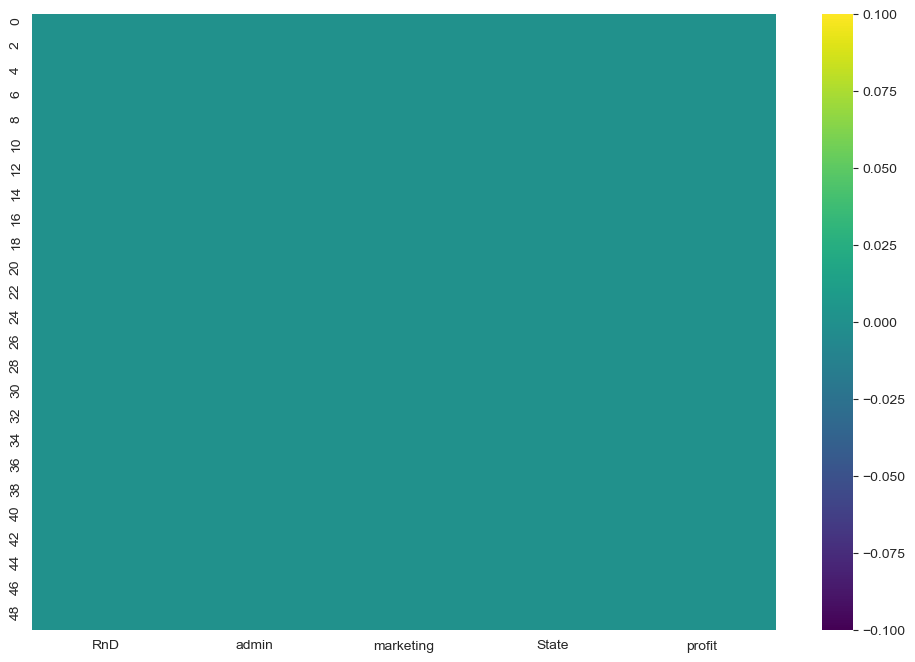

In [84]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(),cmap='viridis')

In [85]:
df[df.duplicated()].shape

(0, 5)

In [86]:
df[df.duplicated()]

,RnD,admin,marketing,State,profit


#### There are no duplicate values in the Dataset
### Visualizing Continuous Datatype for Outlier Detection

In [87]:
continous_feature = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Continous Feature Count = {}'.format(len(continous_feature)))

Continous Feature Count = 4


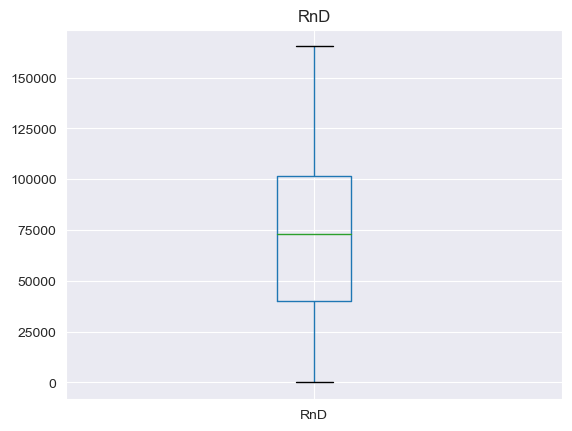

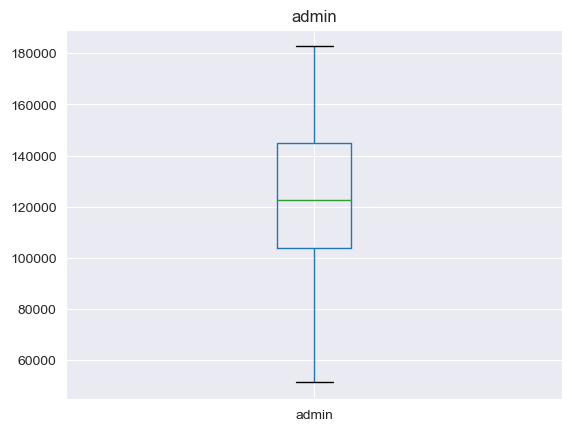

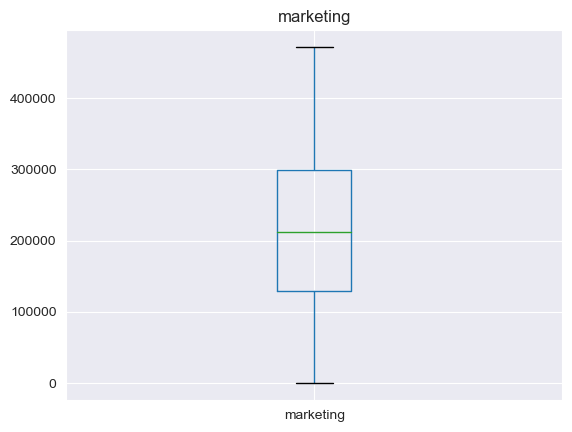

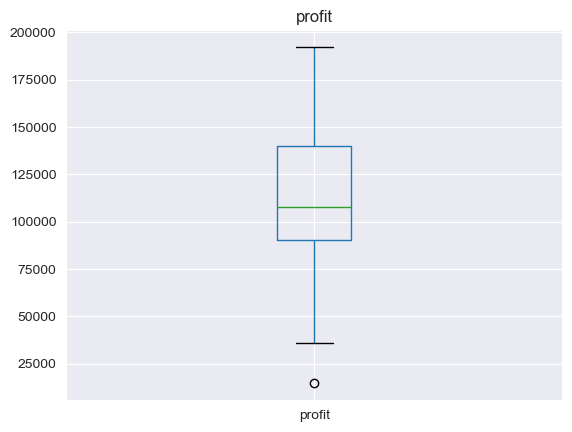

In [88]:
for feature in continous_feature:
    df.boxplot(feature)
    plt.title(feature)
    plt.show()

#### There are outlier in profit which is our Dependent variable but there are no outlier in the independent features
- We need to handle Outlier, the best way sometimes is to remove outliers from the dataset, but that will lead to loss of information as we have a smaller dataset

#### Let's try to find the Outliers in the Profit Dependent Variable
- Transforming variables can also eliminate outliers. The Transformed Variables reduces the variation caused by the extreme values

In [89]:
Q1 = np.quantile(df.profit,0.25)
Q3 = np.quantile(df.profit,0.75)
med = np.median(df.profit)
IQR = Q3 - Q1
upper_bound = Q3 + (1.5*IQR)
lower_bound = Q1 - (1.5*IQR)
print('First Quantile=', Q1,'\n' 'Second Quantile=', med,'\n' 'Third Quantile=', Q3,'\n'
      'Inter-Quartile Range=', IQR,'\n' 'Upper Whisker=', upper_bound,'\n' 'Lower Whisker=', lower_bound)

First Quantile= 90138.9025 
Second Quantile= 107978.19 
Third Quantile= 139765.97749999998 
Inter-Quartile Range= 49627.07499999998 
Upper Whisker= 214206.58999999997 
Lower Whisker= 15698.290000000023


In [90]:
outlier = df.profit[(df.profit<=lower_bound)|(df.profit>=upper_bound)]
print('The outlier in the boxplot:',outlier)

The outlier in the boxplot: 49    14681.4
Name: profit, dtype: float64


In [91]:
display(df[df.index.isin([49])],df.head(5))

,RnD,admin,marketing,State,profit
49,0.0,116983.8,45173.06,California,14681.4


,RnD,admin,marketing,State,profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


{'whiskers': [<matplotlib.lines.Line2D at 0x1d311f201f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d311f20cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d311f204f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1d311f21390>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d311f21510>],
 'means': []}

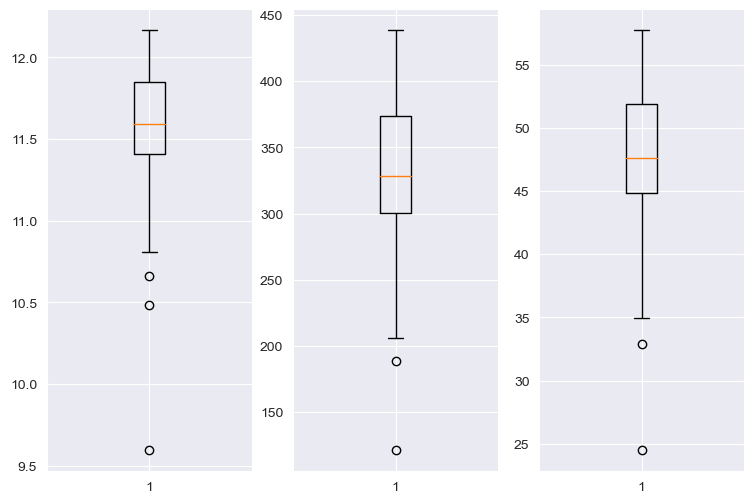

In [92]:
plt.subplots(figsize=(9,6))
plt.subplot(131)
plt.boxplot(np.log(df['profit']))
plt.subplot(132)
plt.boxplot(np.sqrt(df['profit']))
plt.subplot(133)
plt.boxplot(np.cbrt(df['profit']))

#### Even After Transformation we cannot get rid of the outlier
#### Before handling Outliers lets build a model and compare its R-squared value with other techniques to see which technique suits best for this case
#### R-squared measures the strength of the relationship between your model and the dependent variable on a 0 – 100% scale.
#### Measure goodness-of-fit by finding rsquared values (percentage of variance)

In [93]:
raw_model = smf.ols('profit~RnD+admin+marketing',data=df).fit()
raw_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     296.0
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           4.53e-30
Time:                        11:35:38   Log-Likelihood:                -525.39
No. Observations:                  50   AIC:                             1059.
Df Residuals:                      46   BIC:                             1066.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.012e+04   6572.353      7.626      0.000    3.69e+04    6.34e+04
RnD            0.8057      0.045     17.846      0.000       0.715       0.897
admin         -0.0268      0.051     -0.526      0.602      -0.130       0.076
marketing      0.0272      0.016      1.655      0.105      -0.006       0.060
==============================================================================
Omnibus:                       14.838   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.442
Skew:                          -0.949   Prob(JB):                     2.21e-05
Kurtosis:                       5.586   Cond. No.                     1.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
raw_model.rsquared,raw_model.rsquared_adj

(0.9507459940683246, 0.9475337762901719)

### Let's try Median Imputation to handle Outlier in Profit

Text(0.5, 1.0, 'Profit before median imputation')

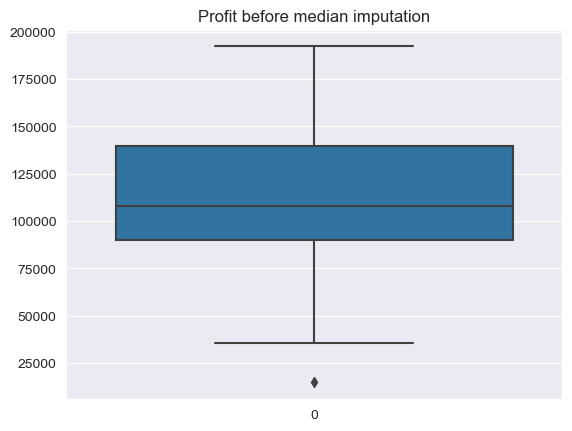

In [95]:
df1 = df.copy()
sns.boxplot(df['profit'])
plt.title('Profit before median imputation')

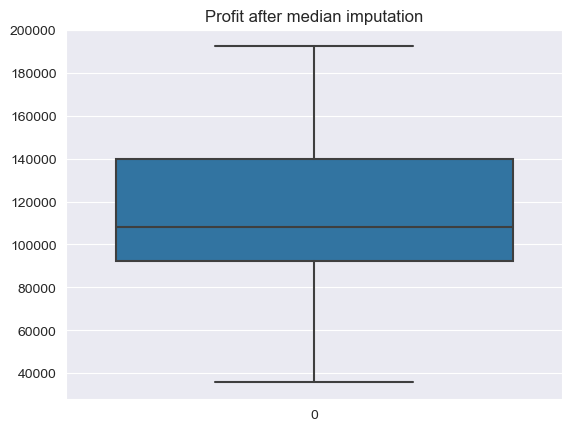

In [96]:
for i in df1['profit']:
    q1 = np.quantile(df['profit'],0.25)
    q3 = np.quantile(df['profit'],0.75)
    med = df['profit'].median()
    iqr = q3-q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)
    if i > upper_bound or i< lower_bound:
        df1['profit'] = df1['profit'].replace(i,med)
sns.boxplot(df1['profit'])
plt.title('Profit after median imputation')
plt.show()

### Let's test our data in model and compare the R-squared with Median imputation data model

In [97]:
after_median_imputation_model = smf.ols('profit~RnD+marketing+admin',data=df1).fit()
after_median_imputation_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     172.3
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           5.06e-25
Time:                        11:35:45   Log-Likelihood:                -534.81
No. Observations:                  50   AIC:                             1078.
Df Residuals:                      46   BIC:                             1085.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.594e+04   7936.330      7.049      0.000       4e+04    7.19e+04
RnD            0.7472      0.055     13.707      0.000       0.638       0.857
marketing      0.0221      0.020      1.112      0.272      -0.018       0.062
admin         -0.0149      0.062     -0.242      0.810      -0.139       0.109
==============================================================================
Omnibus:                       45.356   Durbin-Watson:                   1.603
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.667
Skew:                           2.221   Prob(JB):                     1.82e-51
Kurtosis:                      12.614   Cond. No.                     1.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### As we can see after median imputation the model is not performing well
- Now we have to try something else to get out better results than the raw data
### Let's try Mean Imputation to handle Outlier in Profit

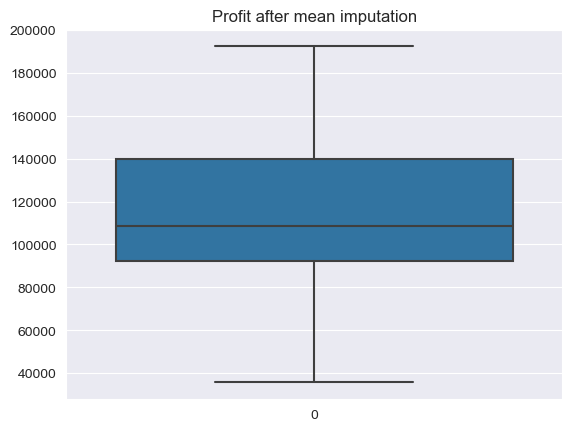

In [98]:
df2=df.copy()
for i in df2['profit']:
    q1 = np.quantile(df2.profit,0.25)
    q3 = np.quantile(df2.profit,0.75)
    med = np.median(df2.profit)
    iqr = q3 - q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    if i > upper_bound or i < lower_bound:
        df2['profit'] = df2['profit'].replace(i, np.mean(df2['profit']))
sns.boxplot(df2['profit'])
plt.title('Profit after mean imputation')
plt.show()

### Let's test our data in model and compare the R-squared with Mean imputation data model

In [99]:
after_mean_imputation_model = smf.ols('profit~RnD+admin+marketing',data=df2).fit()
after_mean_imputation_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     158.8
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           2.82e-24
Time:                        11:35:49   Log-Likelihood:                -536.67
No. Observations:                  50   AIC:                             1081.
Df Residuals:                      46   BIC:                             1089.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.619e+04   8236.731      6.822      0.000    3.96e+04    7.28e+04
RnD            0.7447      0.057     13.162      0.000       0.631       0.859
admin         -0.0144      0.064     -0.226      0.823      -0.143       0.114
marketing      0.0219      0.021      1.061      0.294      -0.020       0.063
==============================================================================
Omnibus:                       50.346   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.669
Skew:                           2.466   Prob(JB):                     1.55e-67
Kurtosis:                      14.107   Cond. No.                     1.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### As we can see after mean imputation the model is not performing well it got a little worse than the median one
- Now we have to try something else to get out better results than the raw data
### The best thing we can do is now to remove the outlier and see the results

In [100]:
df3 = df.copy()
def drop_outliers(data,field_name):
    iqr = 1.5*(np.percentile(data[field_name],75))-1.5*(np.percentile(data[field_name],25))
    data.drop(data[data[field_name]>(iqr+np.percentile(data[field_name],75))].index,inplace=True)
    data.drop(data[data[field_name]<(np.percentile(data[field_name],25)-iqr)].index,inplace=True)

Text(0.5, 1.0, 'Profit after removing outliers')

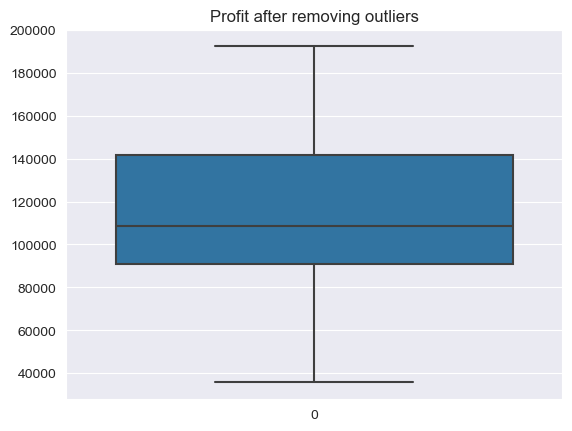

In [101]:
drop_outliers(df3,'profit')
sns.boxplot(df3.profit)
plt.title('Profit after removing outliers')

### Let's test our data in model and compare the R-squared with and without imputation data models

In [102]:
removed_outlier_model =smf.ols('profit~RnD+admin+marketing',data=df3).fit()
removed_outlier_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     372.8
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           8.85e-32
Time:                        11:35:53   Log-Likelihood:                -506.28
No. Observations:                  49   AIC:                             1021.
Df Residuals:                      45   BIC:                             1028.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.238e+04   5542.657      9.451      0.000    4.12e+04    6.35e+04
RnD            0.7830      0.038     20.470      0.000       0.706       0.860
admin         -0.0222      0.043     -0.518      0.607      -0.109       0.064
marketing      0.0252      0.014      1.825      0.075      -0.003       0.053
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.232
Skew:                          -0.082   Prob(JB):                        0.890
Kurtosis:                       2.706   Cond. No.                     1.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### As we can see above, a slightly better score than the raw model
- Note: We will continue with this dataset
### Visualizing the Distribution of Independent Features with the help of Histograms

In [103]:
import pylab
def plot_data(data,feature):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    data[feature].hist()
    plt.subplot(122)
    stats.probplot(data[feature],dist='norm',plot=pylab)

Text(0.5, 1.0, 'Profit')

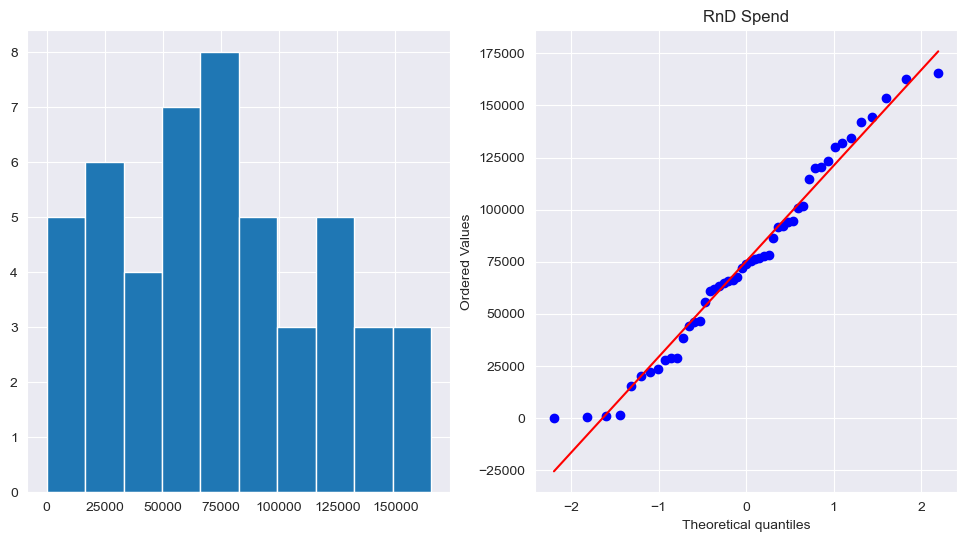

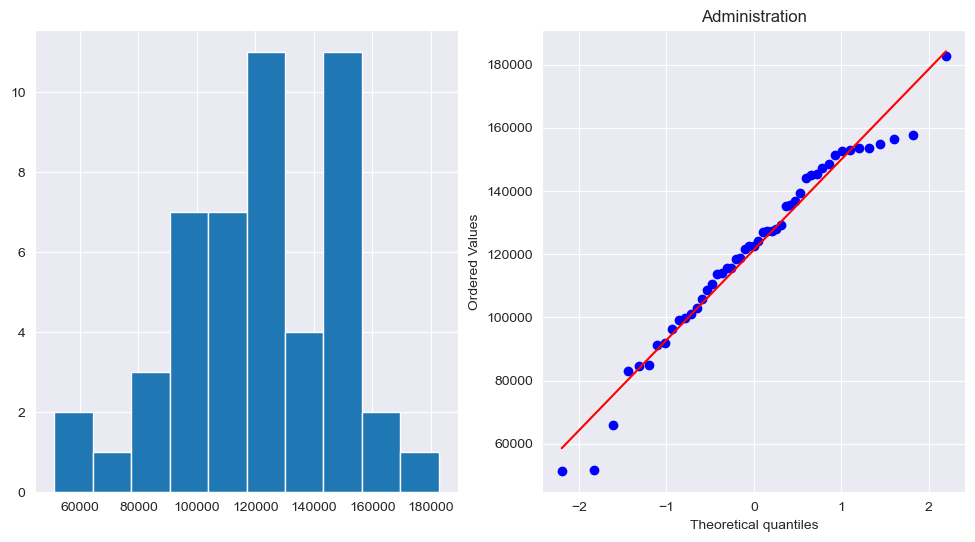

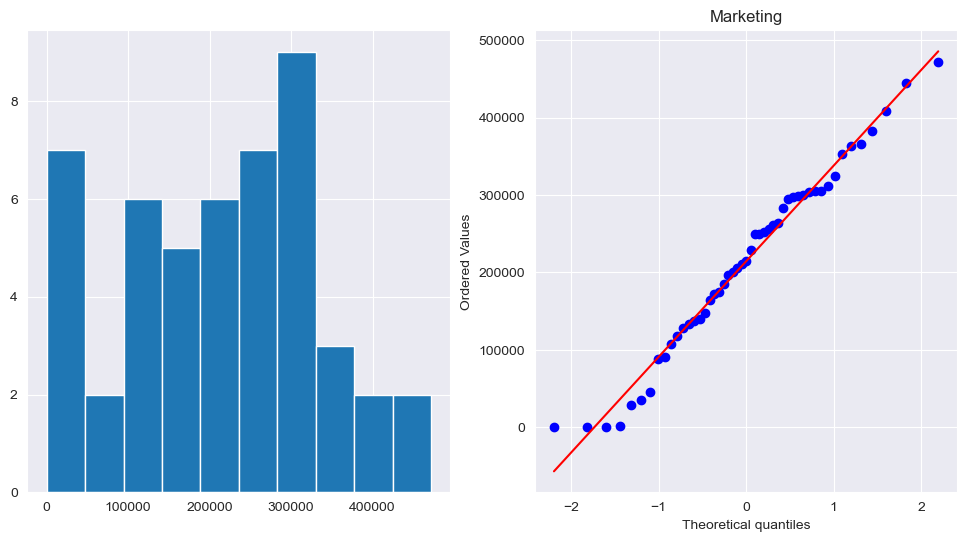

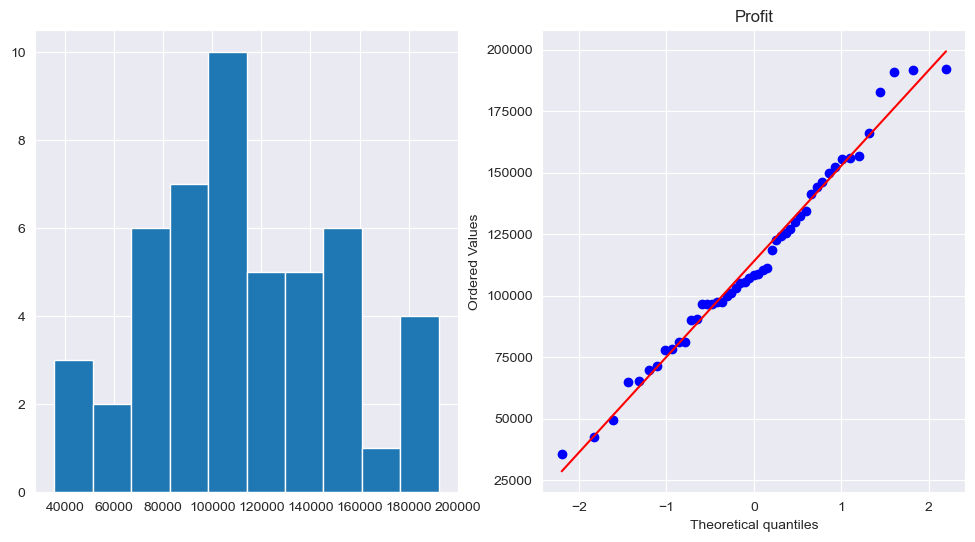

In [104]:
plot_data(df3,'RnD')
plt.title('RnD Spend')
plot_data(df3,'admin')
plt.title('Administration')
plot_data(df3,'marketing')
plt.title('Marketing')
plot_data(df3,'profit')
plt.title('Profit')

### Square root transformation and visualizing the Histogram to determine any possible changes in distribution

Text(0.5, 1.0, 'Profit')

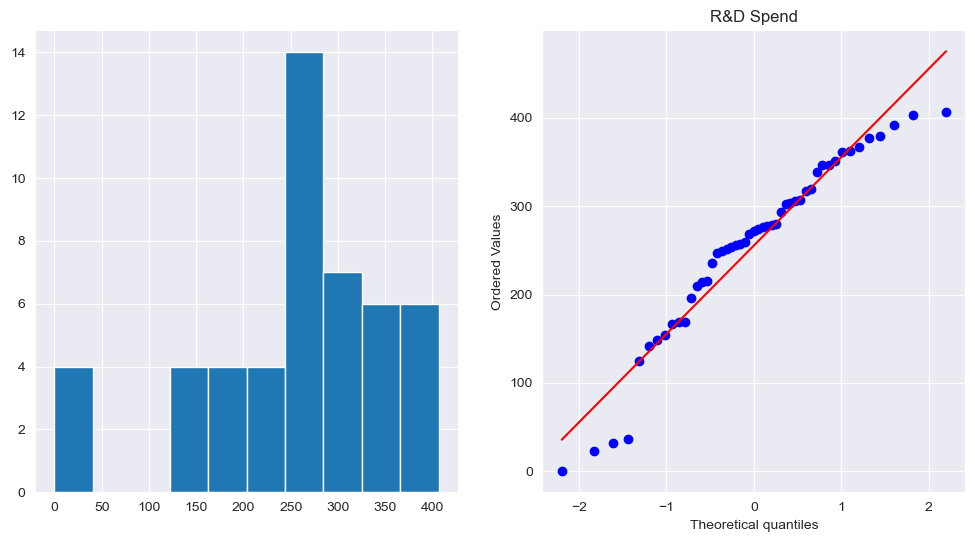

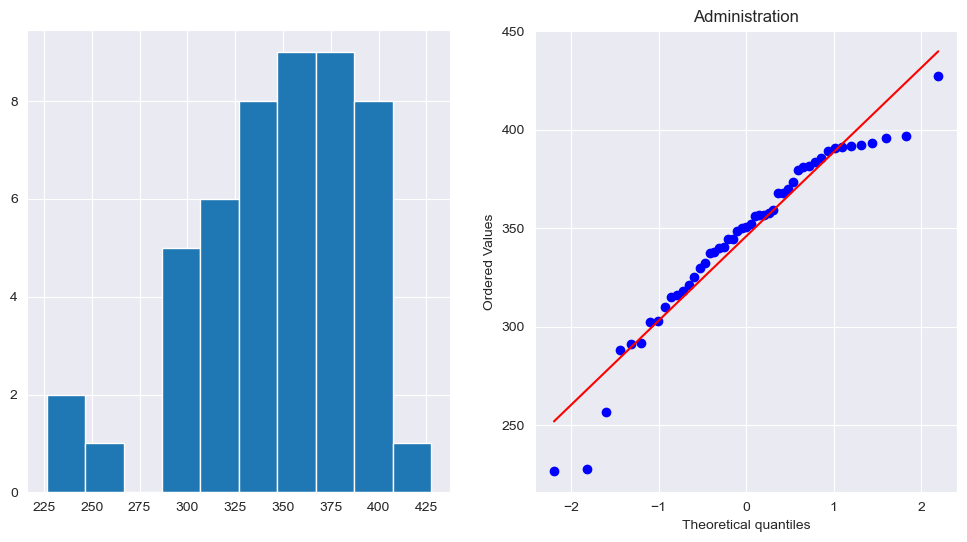

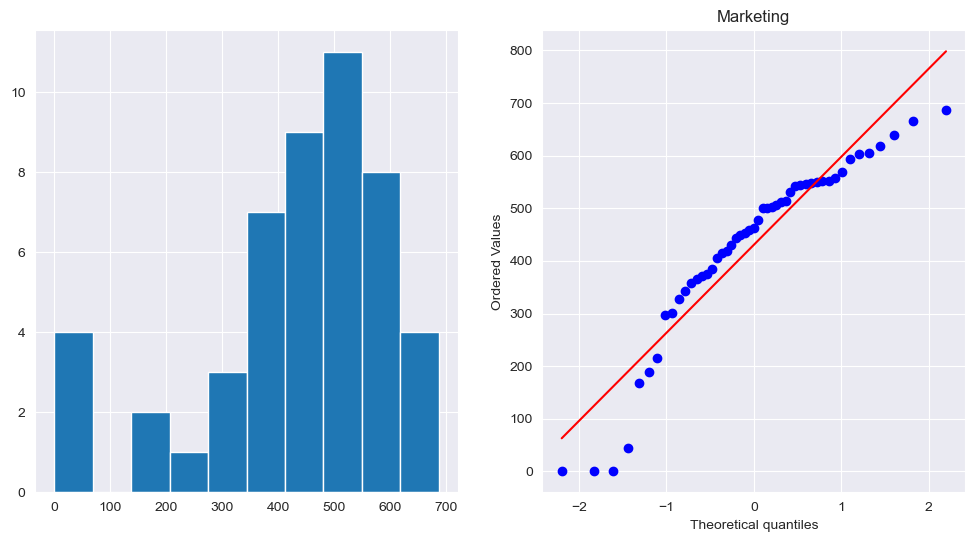

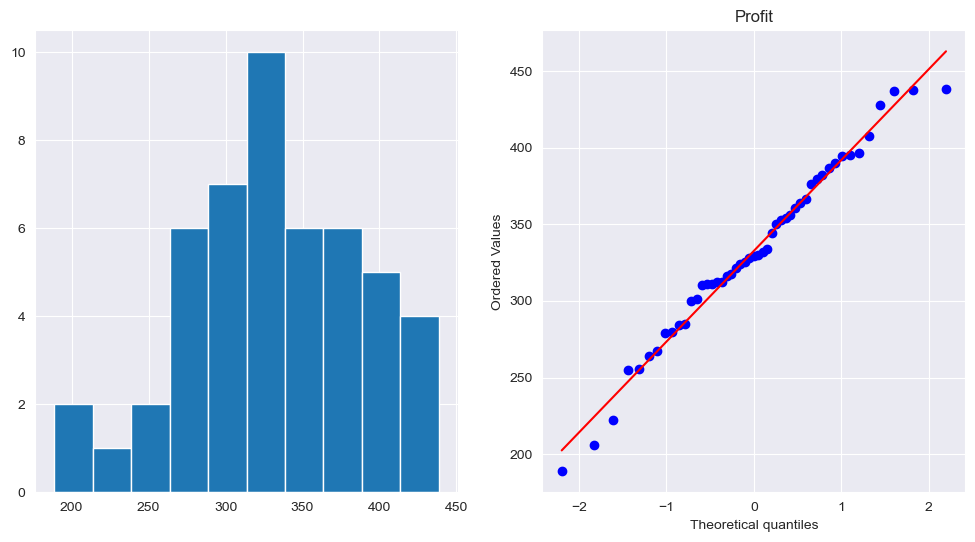

In [105]:
df_sqrt = df3.copy()
df_sqrt[continous_feature]= np.sqrt(df_sqrt[continous_feature])

plot_data(df_sqrt,'RnD')
plt.title('R&D Spend')
plot_data(df_sqrt,'admin')
plt.title('Administration')
plot_data(df_sqrt,'marketing')
plt.title('Marketing')
plot_data(df_sqrt,'profit')
plt.title('Profit')

### Cuberoot transformation and visualizing the Histogram to determine any possible changes in distribution

Text(0.5, 1.0, 'Profit')

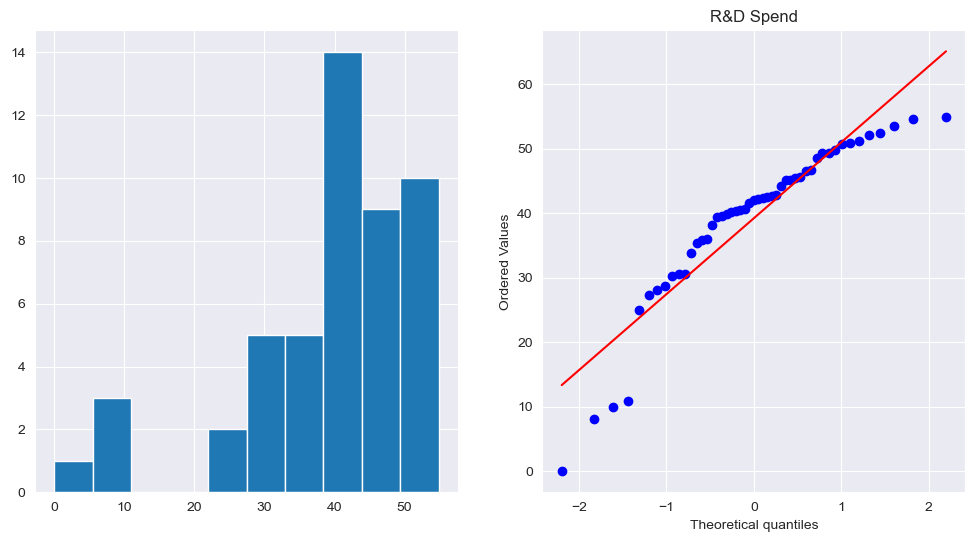

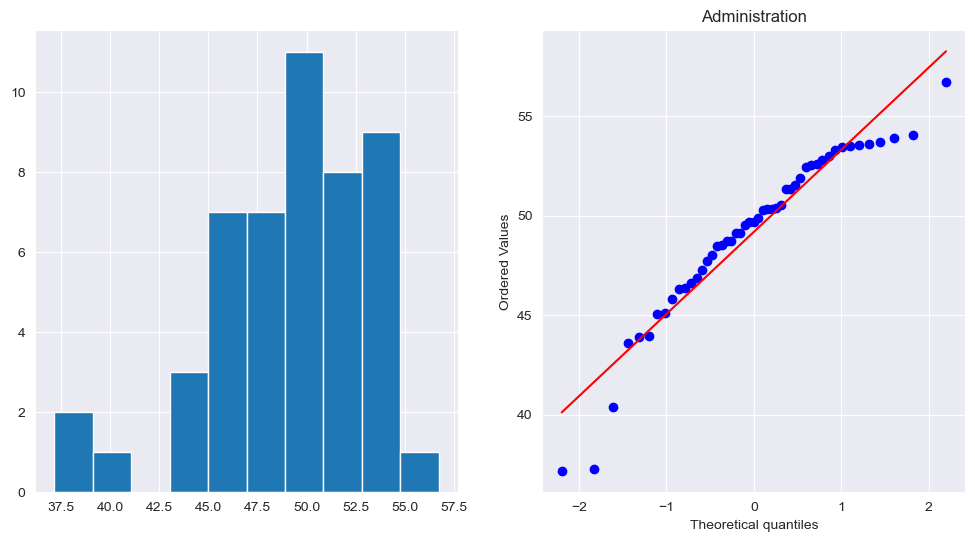

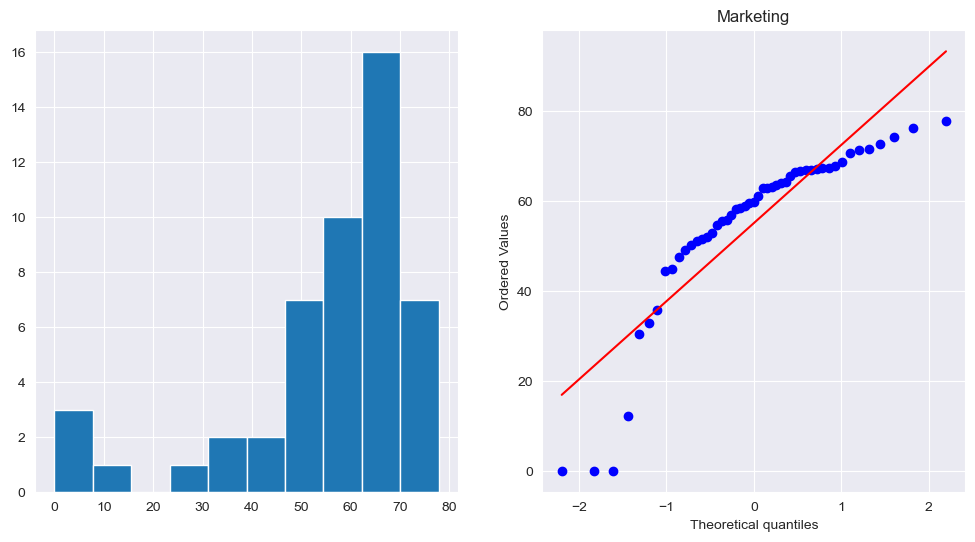

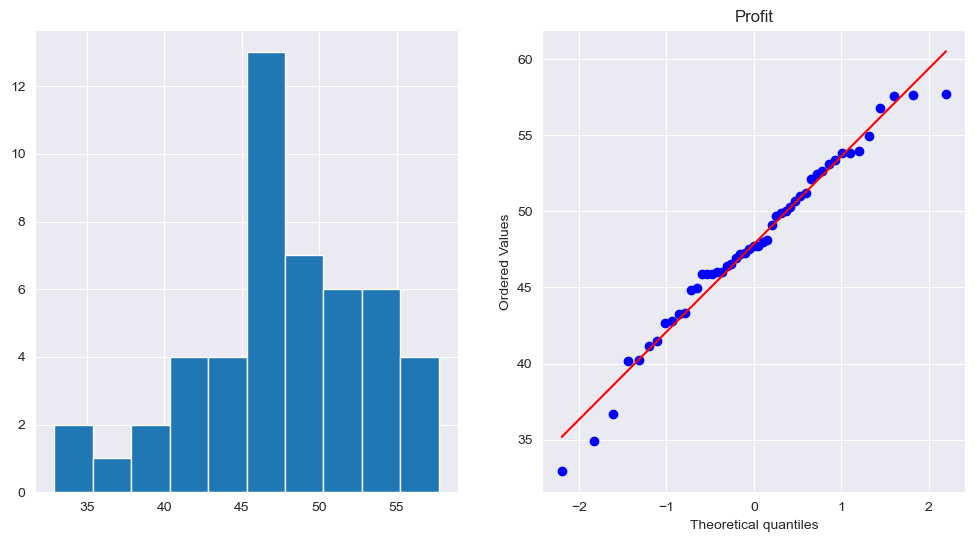

In [106]:
df_cbrt = df3.copy()
df_cbrt[continous_feature]=np.cbrt(df_cbrt[continous_feature])

plot_data(df_cbrt,'RnD')
plt.title('R&D Spend')
plot_data(df_cbrt,'admin')
plt.title('Administration')
plot_data(df_cbrt,'marketing')
plt.title('Marketing')
plot_data(df_cbrt,'profit')
plt.title('Profit')

<Axes: ylabel='State'>

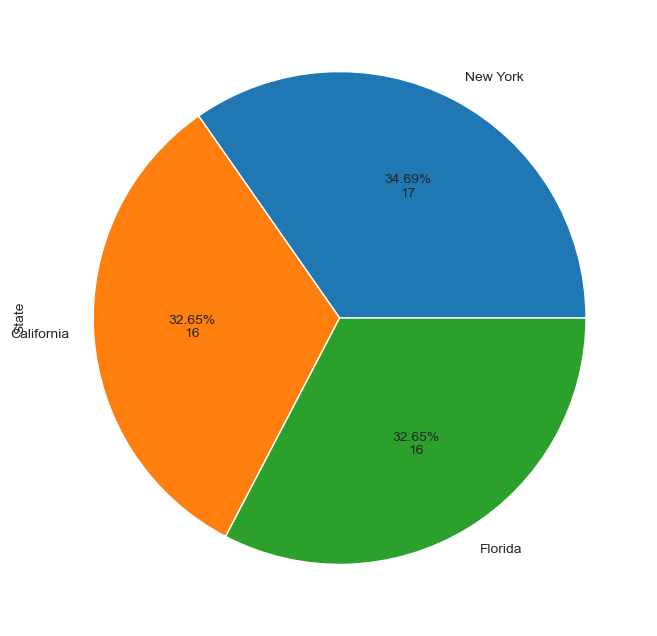

In [107]:
plt.figure(figsize=(8,8))
df3['State'].value_counts().plot(kind='pie',autopct=lambda p:'{:.2f}%\n{:.0f}'.format(p,(p/100)*(df3['State'].value_counts().sum())))

In [108]:
df3['State'].value_counts()

New York      17
California    16
Florida       16
Name: State, dtype: int64

# The Categorical State Feature has balanced data all the unique values are approximately equally distributed
- Note: Most of the Continuous Features visually look normally distributed without any transformation lets have some Hypothetical test to check the normality.
### The Shapiro-Wilk test is a test of normality. It is used to determine whether or not a sample comes from a normal distribution.
- To perform a Shapiro-Wilk test in Python we can use the scipy.stats.shapiro() function, which takes on the following syntax:

In [109]:
df3.columns

Index(['RnD', 'admin', 'marketing', 'State', 'profit'], dtype='object')

In [110]:
from scipy.stats import shapiro

#perform Shapiro-Wilk test
print('R&D Spend feature',shapiro(df3.RnD),'\n'
     'Administration feature',shapiro(df3.admin),'\n'
     'Marketing Spend feature',shapiro(df3.marketing),'\n'
     'Profit feature',shapiro(df3.profit))

R&D Spend feature ShapiroResult(statistic=0.9705320596694946, pvalue=0.25422945618629456) 
Administration feature ShapiroResult(statistic=0.9695430994033813, pvalue=0.23222042620182037) 
Marketing Spend feature ShapiroResult(statistic=0.9757171273231506, pvalue=0.4016808867454529) 
Profit feature ShapiroResult(statistic=0.9793393015861511, pvalue=0.5378792881965637)


### Since the p-values are not less than .05, we fail to reject the null hypothesis.
- We do not have sufficient evidence to say that the sample data does not come from a normal distribution.
### Visualizing the Relation between each independent Feature with respect to the Dependent Feature

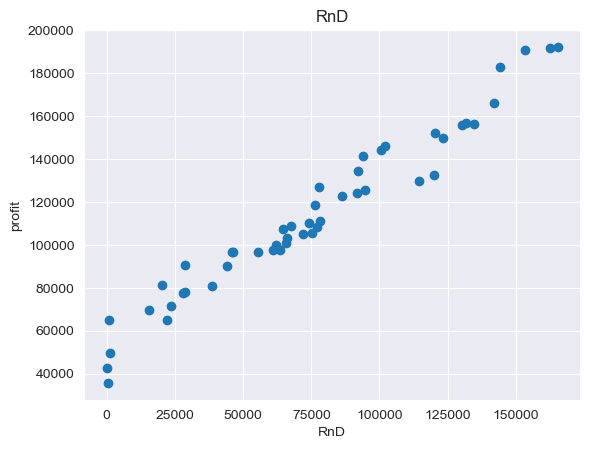

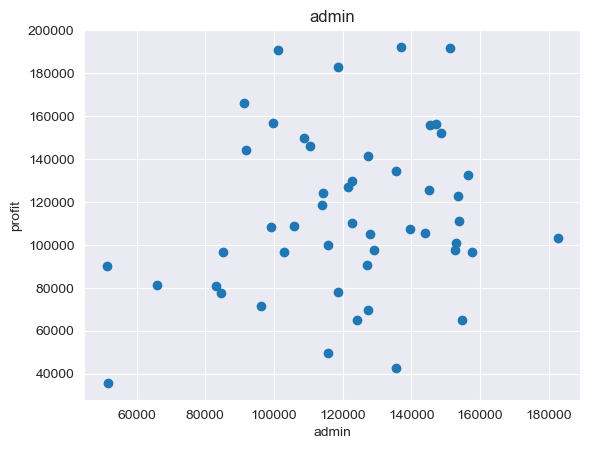

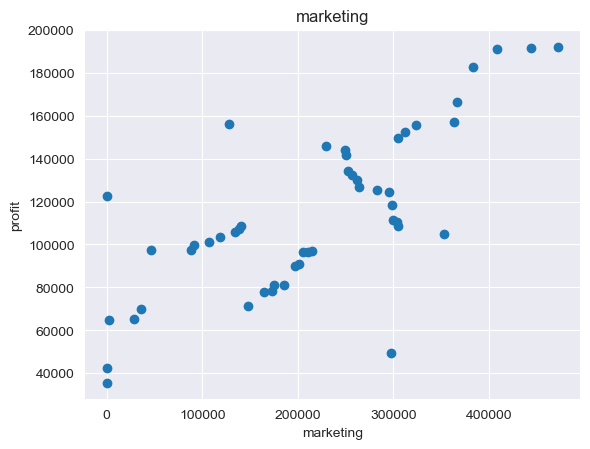

In [111]:
for feature in continous_feature:
    if feature != "profit":
        data = df3.copy()
        plt.scatter(data[feature],data['profit'])
        plt.xlabel(feature)
        plt.ylabel('profit')
        plt.title(feature)
        plt.show()

### R&D feature has a good linear relation with Profit as compare to other features

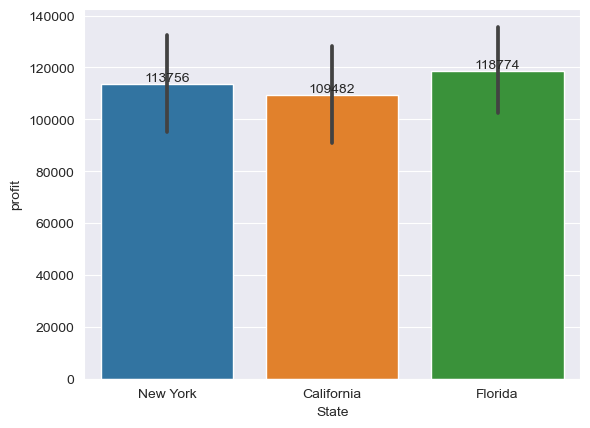

In [112]:
ax = sns.barplot(x='State',y='profit',data=df3)
for i in ax.containers:
    ax.bar_label(i)

### There is'nt much of difference between how much profit each state generates from each other and there is'nt any direct relation
- Note: We are going to drop this feature while building model as it is an irrelevant feature for our inferences

In [113]:
df4 = df3.drop('State',axis=1)
df4.head()

,RnD,admin,marketing,profit
0,165349.20,136897.80,471784.10,192261.83
1,162597.70,151377.59,443898.53,191792.06
2,153441.51,101145.55,407934.54,191050.39
3,144372.41,118671.85,383199.62,182901.99
4,142107.34,91391.77,366168.42,166187.94


In [114]:
df4.corr()

,RnD,admin,marketing,profit
RnD,1.000000,0.243438,0.711654,0.978437
admin,0.243438,1.000000,-0.037280,0.205841
marketing,0.711654,-0.037280,1.000000,0.739307
profit,0.978437,0.205841,0.739307,1.000000


<Axes: >

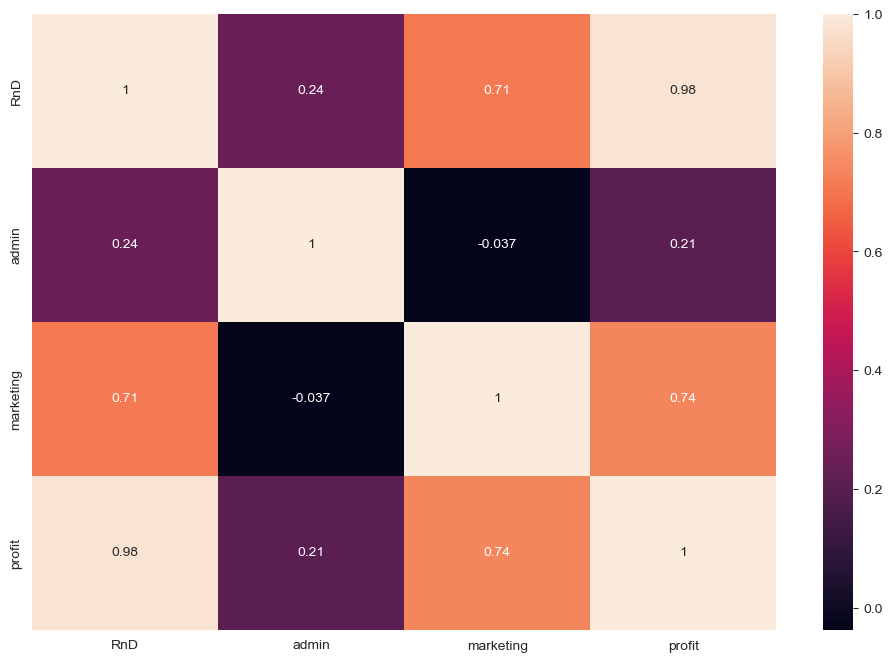

In [115]:
plt.figure(figsize=(12,8))
sns.heatmap(
df4.corr(),
    annot=True
)

### Plotting Correlation on a Pair Plot

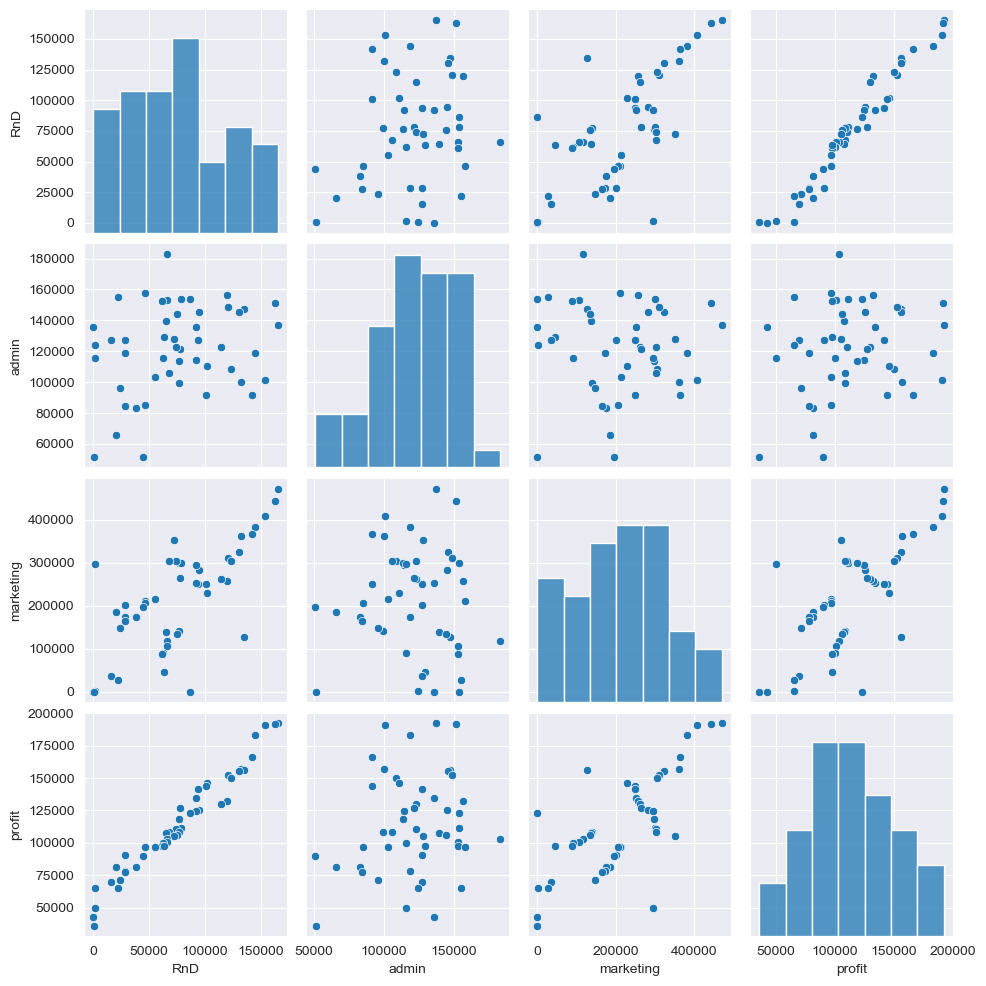

In [116]:
sns.set_style(style='darkgrid')
sns.pairplot(df4)

### R&D has the highest score of correlation with Profit

- Note: Marketing and R&D also have a collinearity among themselves which will affect our model.

### Applying some Data Transformation to increase the linear realtionship and improve our model prediction as well it scores
### Applying Standard Scaler
- For each feature, the Standard Scaler scales the values such that the mean is 0 and the standard deviation is 1(or the variance).
- x_scaled = x – mean/std_dev
- However, Standard Scaler assumes that the distribution of the variable is normal. Thus, in case, the variables are not normally distributed, we either choose a different scaler or first, convert the variables to a normal distribution and then apply this scaler

In [117]:
df_standard_scaled = df4.copy()
features = df_standard_scaled[continous_feature]

In [118]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,RnD,admin,marketing,profit
0,2.018325,0.552080,2.146120,2.071556
1,1.956704,1.069017,1.913596,2.059122
2,1.751650,-0.724297,1.613709,2.039490
3,1.548545,-0.098597,1.407457,1.823808
4,1.497818,-1.072513,1.265442,1.381401


### Now if we check the mean and standard deviation of our scaled data it should have a Mean '0' and Standard deviation '1'

In [119]:
print('Mean''\n',np.round(df_standard_scaled.mean(),1),'\n''Standard Deviation','\n',np.round(df_standard_scaled.std()),1)

Mean
 RnD          0.0
admin       -0.0
marketing   -0.0
profit      -0.0
dtype: float64 
Standard Deviation 
 RnD          1.0
admin        1.0
marketing    1.0
profit       1.0
dtype: float64 1


### For building Multi Linear Resgression there are assumption regarding the data set.
### They are as follows:-
- Feature should be independent of each other there should'nt be any dependency upon each other
- There shouldn't be any other relation but Linear relation amongst model parameters (Hyperparameters of the model the intercept and coefficient)
- Each Feature and Model Error (residuals) should be independent of each other
- Constant Variance (Homoscedasticity) in Error, it should have Normal / Gaussian distribution~N(0,1) and idenpendently and identically distributed.
- There should be a linear relation between the dependent variable and Independent variables
- Note: If any of the above step is not followed our model can't be a good predictor

#### We will Check the above one by one
### Preparing a Model

In [120]:
model = smf.ols('profit~RnD+admin+marketing',data=df_standard_scaled).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     372.8
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           8.85e-32
Time:                        11:36:35   Log-Likelihood:                 10.154
No. Observations:                  49   AIC:                            -12.31
Df Residuals:                      45   BIC:                            -4.741
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.839e-16      0.029  -6.27e-15      1.000      -0.059       0.059
RnD            0.9254      0.045     20.470      0.000       0.834       1.017
admin         -0.0165      0.032     -0.518      0.607      -0.080       0.048
marketing      0.0801      0.044      1.825      0.075      -0.008       0.168
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.232
Skew:                          -0.082   Prob(JB):                        0.890
Kurtosis:                       2.706   Cond. No.                         2.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Testing
### As Y = Beta0 + Beta1(X1) + Beta2(X2) +Beta3(X3) + .................. + Beta n(Xn)
### Finding Coefficient Parameters (Beta0 and Beta1's values)

In [121]:
model.params

Intercept   -1.838807e-16
RnD          9.254411e-01
admin       -1.646059e-02
marketing    8.009988e-02
dtype: float64

Assupmtion for multi linear Regression fails

Feature should be independent of each other there should'nt be any dependency upon each other

In [122]:
#finding tvalues and pvalues
display(np.round(model.tvalues,3),np.round(model.pvalues,3))

Intercept    -0.000
RnD          20.470
admin        -0.518
marketing     1.825
dtype: float64

Intercept    1.000
RnD          0.000
admin        0.607
marketing    0.075
dtype: float64

### Here, (Intercept)Beta0 p_value ~ 1
### Hypothesis testing of X variable by finding test_statistics and P_values for Beta1 i.e if (P_value < α=0.05 ; Reject Null)
### Null Hypothesis as Beta1=0 (No Slope) and Alternate Hypthesis as Beta1≠0 (Some or significant Slope)
### Observation
- (Intercept) Beta0: tvalue=-0.000 , pvalue=1.000
- (RnD) Beta1: tvalue=20.470, pvalue= 0.000
- (admin) Beta2: tvalue=-0.518, pvalue= 0.607
- (marketing) Beta3: tvalue=1.825, pvalue= 0.075
- If (pvalue=0)<(α=0.05); Reject Null hyp. Thus, X(RnD) variable has good slope and variance w.r.t Y(profit) variable.
- If (pvalue=0)>(α=0.05); We fail to reject Null hyp. Thus, X1(admin) and X2(marketing) variable doesn't have good slope
- Until further tests
#### Note
- We are now going to perform Simple Linear Regression to separately check the dependency between those feature with Target feature
- Let's first compare models by their R-Squared and p_values.

In [123]:
admin_slr_model = smf.ols("profit~admin",data = df_standard_scaled).fit()
admin_slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.080
Date:                Sat, 13 Apr 2024   Prob (F-statistic):              0.156
Time:                        11:36:39   Log-Likelihood:                -68.467
No. Observations:                  49   AIC:                             140.9
Df Residuals:                      47   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.839e-16      0.143  -1.29e-15      1.000      -0.287       0.287
admin          0.2058      0.143      1.442      0.156      -0.081       0.493
==============================================================================
Omnibus:                        1.016   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.602   Jarque-Bera (JB):                1.052
Skew:                           0.310   Prob(JB):                        0.591
Kurtosis:                       2.639   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
# Finding tvalues and pvalues
display(np.round(admin_slr_model.tvalues,3), np.round(admin_slr_model.pvalues,3))

Intercept   -0.000
admin        1.442
dtype: float64

Intercept    1.000
admin        0.156
dtype: float64

### Observation:
- (Intercept) Beta0: tvalue=-0.000 , pvalue=1.000
- (admin) Beta1: tvalue=1.442, pvalue= 0.156
- If (pvalue=0)<(α=0.05); Reject Null hyp.
- If (pvalue=0)>(α=0.05); We fail to reject Null hyp. Thus, X(admin) variable doesn't has good slope
- Until further tests

In [125]:
marketing_slr_model = smf.ols('profit~marketing',data=df_standard_scaled).fit()
marketing_slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     56.66
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           1.30e-09
Time:                        11:36:42   Log-Likelihood:                -50.150
No. Observations:                  49   AIC:                             104.3
Df Residuals:                      47   BIC:                             108.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.839e-16      0.098  -1.87e-15      1.000      -0.198       0.198
marketing      0.7393      0.098      7.527      0.000       0.542       0.937
==============================================================================
Omnibus:                        4.458   Durbin-Watson:                   1.140
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                4.096
Skew:                          -0.303   Prob(JB):                        0.129
Kurtosis:                       4.281   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
# Finding tvalues and pvalues
display(np.round(marketing_slr_model.tvalues,3), np.round(marketing_slr_model.pvalues,3))

Intercept   -0.000
marketing    7.527
dtype: float64

Intercept    1.0
marketing    0.0
dtype: float64

### Observation:
- (Intercept) Beta0: tvalue=-0.000 , pvalue=1.000
- (marketing) Beta1: tvalue=7.527, pvalue= 0.0
- If (pvalue=0)<(α=0.05); Reject Null hyp. Thus, X(marketing) variable has good slope
- If (pvalue=0)>(α=0.05); We fail to reject Null hyp.
- Until further tests

In [127]:
admin_plus_marketing= smf.ols('profit~admin+marketing', data =df_standard_scaled).fit()
# Finding rsquared values
admin_plus_marketing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     34.66
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           6.59e-10
Time:                        11:36:44   Log-Likelihood:                -47.010
No. Observations:                  49   AIC:                             100.0
Df Residuals:                      46   BIC:                             105.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.839e-16      0.093  -1.97e-15      1.000      -0.187       0.187
admin          0.2337      0.093      2.508      0.016       0.046       0.421
marketing      0.7480      0.093      8.027      0.000       0.560       0.936
==============================================================================
Omnibus:                        6.637   Durbin-Watson:                   1.193
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                7.219
Skew:                          -0.454   Prob(JB):                       0.0271
Kurtosis:                       4.646   Cond. No.                         1.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Let's Try another Test by Calculating VIF ( Variance Inflation Factor )
- This helps to check the dependency among the features by building a model without the target and testing various combination among the features

In [128]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
x = df4[['marketing','admin','RnD']]
vif_data = pd.DataFrame()
vif_data['Features'] = x.columns
vif_data['VIF'] = [vif(x.values,i) for i in range(len(x.columns))]
vif_data.sort_values(by = ['VIF'])

,Features,VIF
1,admin,4.218831
0,marketing,7.589312
2,RnD,8.602235


In [129]:
# Method to calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
x = df4[['marketing','RnD']]
vif_data = pd.DataFrame()
vif_data['Features'] = x.columns
vif_data['VIF'] = [vif(x.values, i) for i in range(len(x.columns))]
vif_data.sort_values(by = ['VIF'])

,Features,VIF
0,marketing,7.186744
1,RnD,7.186744


### Some of the variables has VIF>5, Yes there is Collinearity, hence we cannot consider all varaibles in Regression equation
### Let's build two model in each model one of the feature will not be present and then we will come to an conclusion to remove which of the feature by comparing the model parameters

In [130]:
admin_present_model = smf.ols('profit~RnD+admin',data= df_standard_scaled).fit()
admin_present_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     530.6
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           1.69e-32
Time:                        11:36:50   Log-Likelihood:                 8.4042
No. Observations:                  49   AIC:                            -10.81
Df Residuals:                      46   BIC:                            -5.133
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.839e-16      0.030  -6.12e-15      1.000      -0.060       0.060
RnD            0.9868      0.031     31.847      0.000       0.924       1.049
admin         -0.0344      0.031     -1.110      0.273      -0.097       0.028
==============================================================================
Omnibus:                        0.444   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.801   Jarque-Bera (JB):                0.245
Skew:                          -0.173   Prob(JB):                        0.885
Kurtosis:                       2.972   Cond. No.                         1.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1


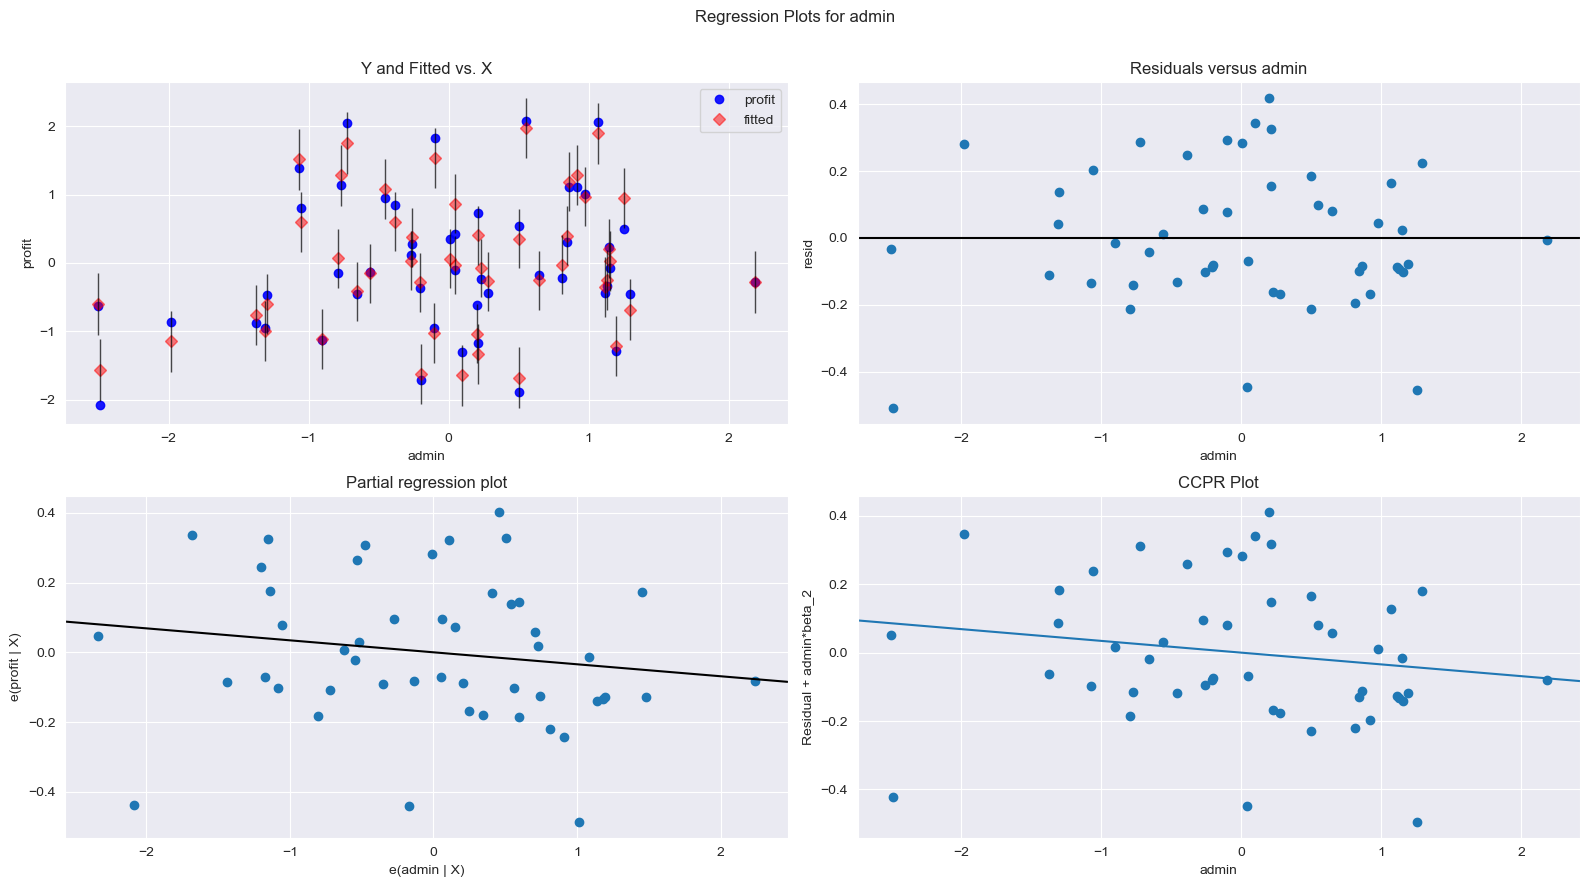

In [131]:
fig = plt.figure(figsize = (16,9))
sm.graphics.plot_regress_exog(admin_present_model, 'admin', fig=fig)
plt.show()

In [132]:
marketing_present_model= smf.ols('profit~RnD+marketing', data= df_standard_scaled).fit()
marketing_present_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     568.0
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           3.74e-33
Time:                        11:36:52   Log-Likelihood:                 10.009
No. Observations:                  49   AIC:                            -14.02
Df Residuals:                      46   BIC:                            -8.342
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.839e-16      0.029  -6.32e-15      1.000      -0.059       0.059
RnD            0.9164      0.041     22.136      0.000       0.833       1.000
marketing      0.0871      0.041      2.104      0.041       0.004       0.170
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.273
Skew:                          -0.051   Prob(JB):                        0.872
Kurtosis:                       2.649   Cond. No.                         2.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1


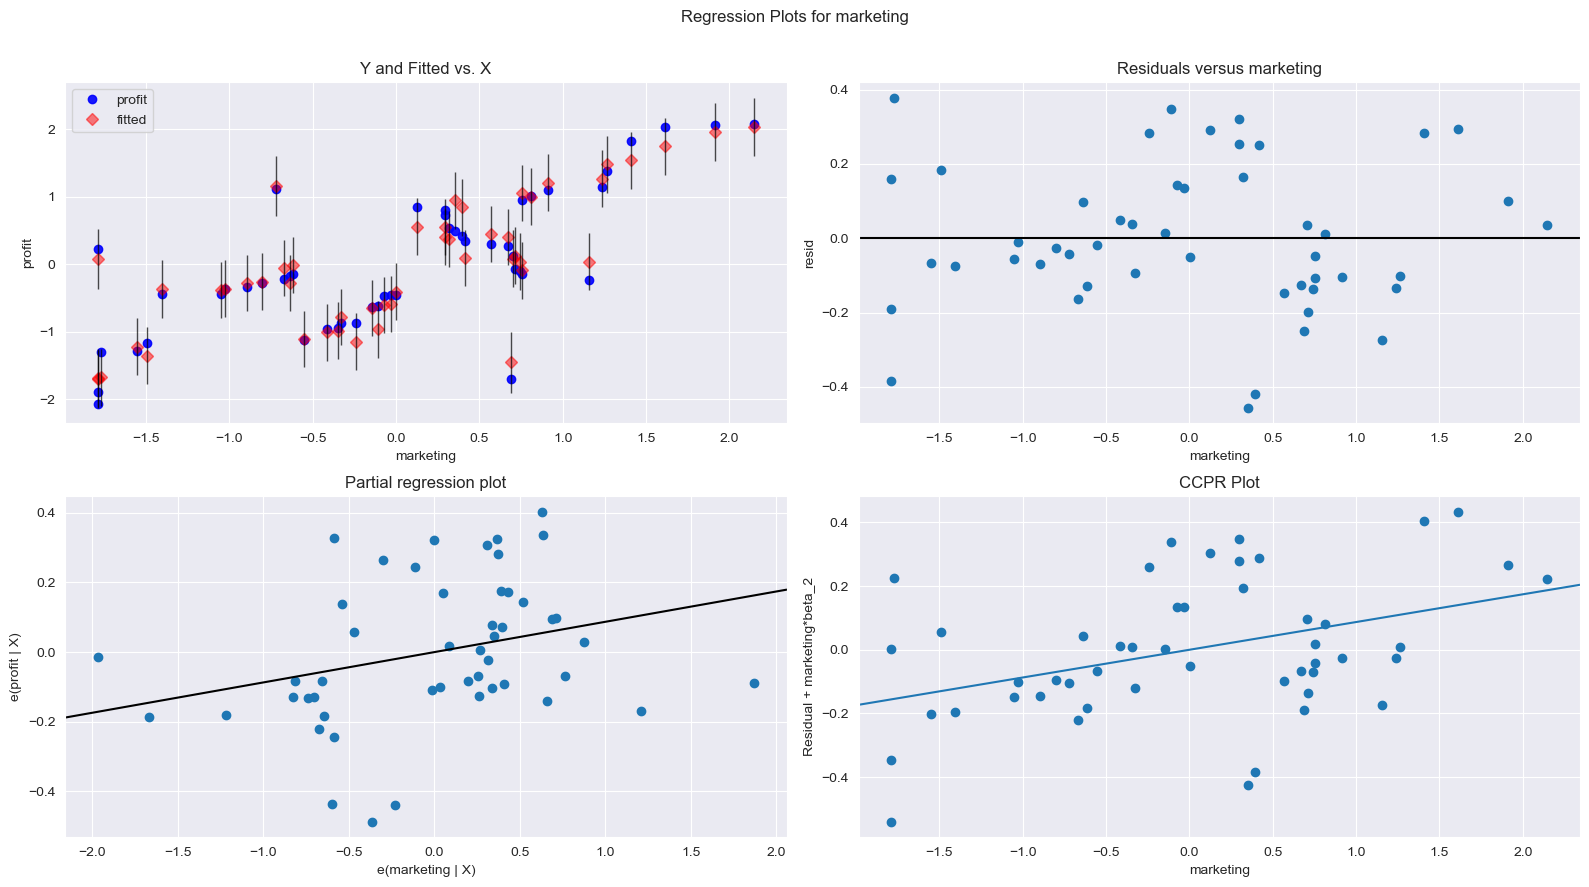

In [133]:
fig = plt.figure(figsize = (16,9))
sm.graphics.plot_regress_exog(marketing_present_model, 'marketing', fig=fig)
plt.show()

In [134]:
only_RnD_model= smf.ols('profit~RnD', data= df_standard_scaled).fit()
only_RnD_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1055.
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           7.56e-34
Time:                        11:36:54   Log-Likelihood:                 7.7569
No. Observations:                  49   AIC:                            -11.51
Df Residuals:                      47   BIC:                            -7.730
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.839e-16      0.030   -6.1e-15      1.000      -0.061       0.061
RnD            0.9784      0.030     32.477      0.000       0.918       1.039
==============================================================================
Omnibus:                        0.070   Durbin-Watson:                   1.372
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.203
Skew:                          -0.080   Prob(JB):                        0.903
Kurtosis:                       2.728   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1


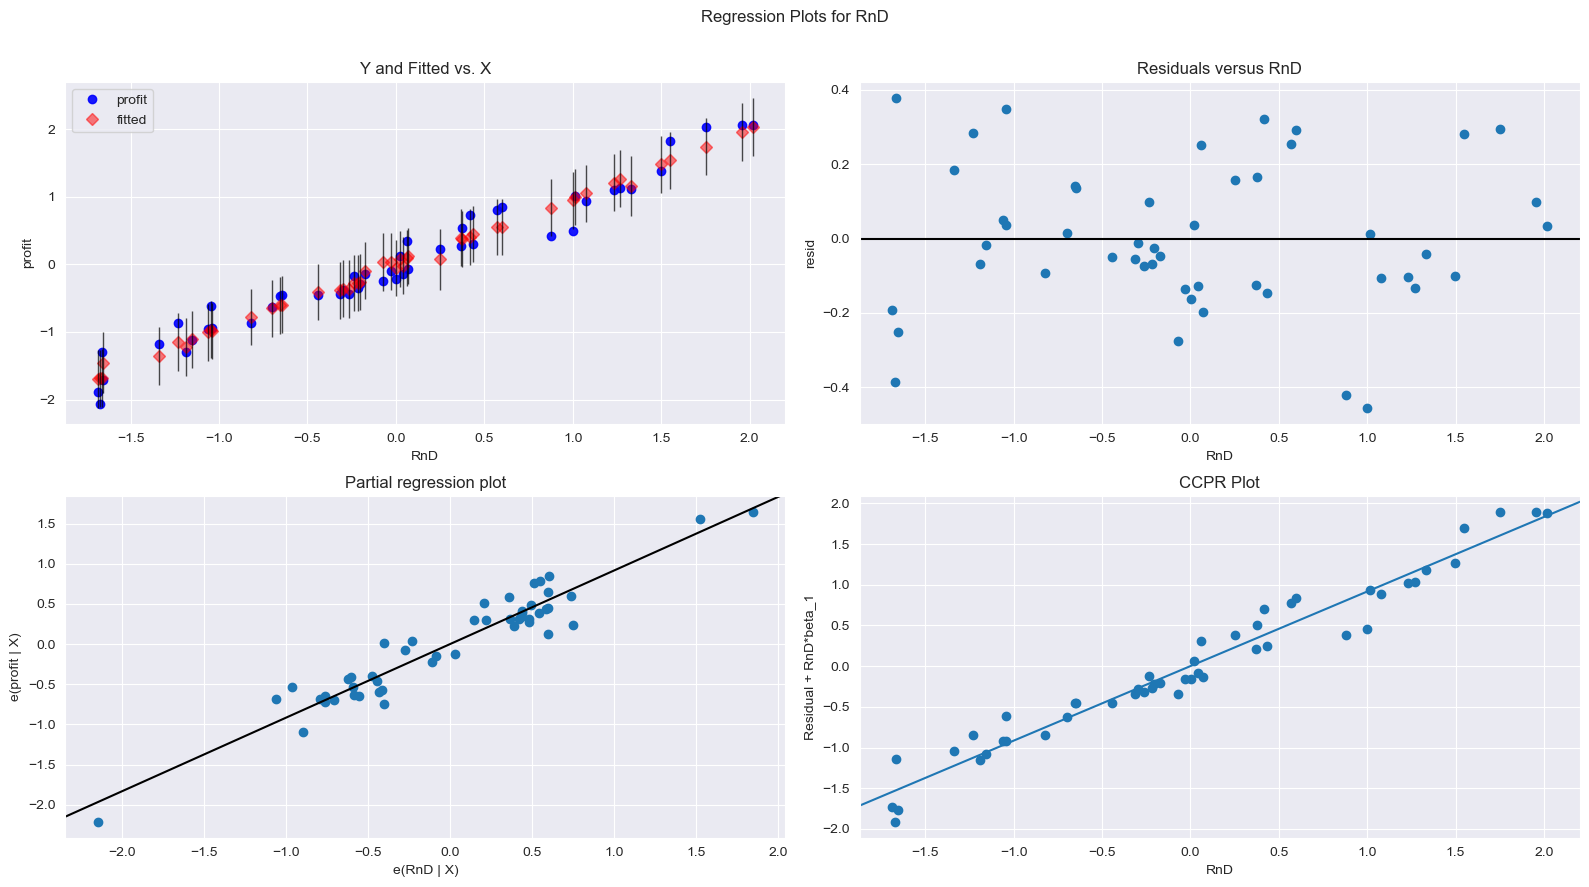

In [135]:
fig = plt.figure(figsize = (16,9))
sm.graphics.plot_regress_exog(marketing_present_model, 'RnD', fig=fig)
plt.show()

### Observation: All our Assumptions are satisfied by the above model
- Feature should be independent of each other there should'nt be any dependency upon each other
- it is satisfied by the model using Marketing feature
- While building a model using Marketing we got better results better AIC, BIC, R-squared, R-squared adjusted, p_value(Test of -  Independence) and F-statistics score by comparing it with the model in which Adminstration feature was used.
### Let's compare the residuals of both the models to come up with an conclusion
### Model Validation
### Comparing different models with respect to their Root Mean Squared Errors
### We will analyze Mean Squared Error (MSE) or Root Mean Squared Error (RMSE) — AKA the average distance (squared to get rid of negative numbers) between the model’s predicted target value and the actual target value.

In [136]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [137]:
df4.columns

Index(['RnD', 'admin', 'marketing', 'profit'], dtype='object')

### Using all features

In [138]:
x = df4.drop('profit',axis=1).values
y = df4.iloc[:,3:].values.reshape(-1,1)
print("Shape of x: ",x.shape)
print("Shape of y: ",y.shape)

Shape of x:  (49, 3)
Shape of y:  (49, 1)


In [139]:
# Splitting the data into training set and testing set
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)
print("Shape of x_train: ",x_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test: ",y_test.shape)

Shape of x_train:  (36, 3)
Shape of x_test:  (13, 3)
Shape of y_train:  (36, 1)
Shape of y_test:  (13, 1)


In [140]:
transformer_x = StandardScaler().fit(x_train)
transformer_y = StandardScaler().fit(y_train)
x_train_scal = transformer_x.transform(x_train)
x_test_scal = transformer_x.transform(x_test)
y_train_scal = transformer_y.transform(y_train)
y_test_scal = transformer_y.transform(y_test)

# Linear Regression
regressor_linear = LinearRegression()
regressor_linear.fit(x_train_scal,y_train_scal)

LinearRegression()

In [141]:
# scale the test dataset
x_test_scaled = transformer_x.transform(x_test)

# Predict with the trained model
prediction = regressor_linear.predict(x_test_scaled)

# Inverse transform the prediction
prediction_unscaled = transformer_y.inverse_transform(prediction)

from sklearn.metrics import r2_score

# Predicting Cross Validation Score the Test set results
cv_linear = cross_val_score(estimator = regressor_linear, X = x_train_scal, y = y_train_scal, cv=10)

# Predicting R2 Score the Train set results
y_pred_linear_train = regressor_linear.predict(x_train_scal)
r2_score_all_feature_train = r2_score(y_train_scal,y_pred_linear_train)

# Predicting R2 Score the Test set results
y_pred_linear_test = regressor_linear.predict(x_test_scal)
r2_score_all_feature_test = r2_score(y_test_scal, y_pred_linear_test)

# Predicting RMSE the Test set results
rmse_linear_using_all_features = (np.sqrt(mean_squared_error(y_test, prediction_unscaled)))
print("CV: ", cv_linear.mean())
print('R2_score (train): ', r2_score_all_feature_train)
print('R2_score (test): ', r2_score_all_feature_test)
print("RMSE using all features: ", rmse_linear_using_all_features)

CV:  0.9059814869956572
R2_score (train):  0.9650197585709105
R2_score (test):  0.9341582772336137
RMSE using all features:  8385.783571480782


### Using RnD and Marketing Feature

In [148]:
x = df4.drop(['profit','admin'],axis=1).values
y = df4.iloc[:,3:].values.reshape(-1,1)
print("Shape of x: ",x.shape)
print("Shape of y: ",y.shape)

Shape of x:  (49, 2)
Shape of y:  (49, 1)


In [149]:
# Splitting the data into training set and testing set
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)
print("Shape of x_train: ",x_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test: ",y_test.shape)

Shape of x_train:  (36, 2)
Shape of x_test:  (13, 2)
Shape of y_train:  (36, 1)
Shape of y_test:  (13, 1)


In [150]:
print(x_test.shape)
print(x_train.shape)

(13, 2)
(36, 2)


In [151]:
transformer_x = StandardScaler().fit(x_train)
transformer_y = StandardScaler().fit(y_train)
x_train_scal = transformer_x.transform(x_train)
x_test_scal = transformer_x.transform(x_test)
y_train_scal = transformer_y.transform(y_train)
y_test_scal = transformer_y.transform(y_test)

# Linear Regression
regressor_linear = LinearRegression()
regressor_linear.fit(x_train_scal,y_train_scal)

LinearRegression()

In [154]:
# Scale the test dataset
X_test_scaled = transformer_x.transform(x_test)

# Predict with the trained model
prediction = regressor_linear.predict(X_test_scaled)

# Inverse transform the prediction
prediction_unscaled = transformer_y.inverse_transform(prediction)

from sklearn.metrics import r2_score

# Predicting Cross Validation Score the Test set results
cv_linear = cross_val_score(estimator = regressor_linear, X = x_train_scal, y = y_train_scal, cv = 10)

# Predicting R2 Score the Train set results
y_pred_linear_train = regressor_linear.predict(x_train_scal)
r2_score_rnd_and_marketing_train = r2_score(y_train_scal, y_pred_linear_train)

# Predicting R2 Score the Test set results
y_pred_linear_test = regressor_linear.predict(x_test_scal)
r2_score_rnd_and_marketing_test = r2_score(y_test_scal, y_pred_linear_test)

# Predicting RMSE the Test set results
rmse_linear_using_RnD_and_marketing = (np.sqrt(mean_squared_error(y_test, prediction_unscaled)))
print("CV: ", cv_linear.mean())
print('R2_score (train): ', r2_score_rnd_and_marketing_train)
print('R2_score (test): ', r2_score_rnd_and_marketing_test)
print("RMSE using RnD and Marketing feature: ", rmse_linear_using_RnD_and_marketing)

CV:  0.9114070932851247
R2_score (train):  0.9643536571553787
R2_score (test):  0.939185037123506
RMSE using RnD and Marketing feature:  8059.317765282765


### Using Only RnD feature

In [155]:
x = df4.iloc[:,:1].values
y = df4.iloc[:,3:].values.reshape(-1,1)
print("Shape of x: ",x.shape)
print("Shape of y:",y.shape)

Shape of x:  (49, 1)
Shape of y: (49, 1)


In [158]:
# Splitting the dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train:  (36, 1)
Shape of y_train:  (36, 1)
Shape of x_test:  (13, 1)
Shape of y_test: (13, 1)


In [159]:
from sklearn.preprocessing import StandardScaler

#Scaling
transformer_x = StandardScaler().fit(x_train)
transformer_y = StandardScaler().fit(y_train)
x_train_scal = transformer_x.transform(x_train)
x_test_scal = transformer_x.transform(x_test)
y_train_scal = transformer_y.transform(y_train)
y_test_scal = transformer_y.transform(y_test)

# Linear Regression
regressor_linear_using_rnd = LinearRegression()
regressor_linear_using_rnd.fit(x_train_scal,y_train_scal)

LinearRegression()

In [162]:
# Scale the test dataset
X_test_scaled = transformer_x.transform(x_test)

# Predict with the trained model
prediction = regressor_linear_using_rnd.predict(X_test_scaled)

# Inverse transform the prediction
prediction_unscaled = transformer_y.inverse_transform(prediction)

from sklearn.metrics import r2_score

# Predicting Cross Validation Score the Test set results
cv_linear = cross_val_score(estimator = regressor_linear_using_rnd, X = x_train_scal, y = y_train_scal, cv = 10)

# Predicting R2 Score the Train set results
y_pred_linear_train = regressor_linear_using_rnd.predict(x_train_scal)
r2_score_rnd_train = r2_score(y_train_scal, y_pred_linear_train)

# Predicting R2 Score the Test set results
y_pred_linear_test = regressor_linear_using_rnd.predict(x_test_scal)
r2_score_rnd_test = r2_score(y_test_scal, y_pred_linear_test)

# Predicting RMSE on Test set results
rmse_linear_using_only_RnD = (np.sqrt(mean_squared_error(y_test, prediction_unscaled)))
print("CV: ", cv_linear.mean())
print('R2_score (train): ', r2_score_rnd_train)
print('R2_score (test): ', r2_score_rnd_test)
print("RMSE using only RnD feature: ", rmse_linear_using_only_RnD)

CV:  0.8900789292733178
R2_score (train):  0.957733077239081
R2_score (test):  0.9521017609333128
RMSE using only RnD feature:  7152.417057875892


In [163]:
rmse_compare = {'Using All Features Model': rmse_linear_using_all_features,'Using RnD and Marketing Feature Model': rmse_linear_using_RnD_and_marketing, 'Using only R&D Feauture Model': rmse_linear_using_only_RnD}
min(rmse_compare, key=rmse_compare.get)

'Using only R&D Feauture Model'

### Observation: The Model that was build without using Administration and Marketing feature performed very well.
- Scoring minimumn Root mean squared error and maximum R-squared and adjusted R-squared and highest linear relation
- Note: For further We are going to use the model whihc was build by using only R&D feature

In [164]:
final_model = smf.ols('profit~RnD',data=df_standard_scaled).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1055.
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           7.56e-34
Time:                        13:08:20   Log-Likelihood:                 7.7569
No. Observations:                  49   AIC:                            -11.51
Df Residuals:                      47   BIC:                            -7.730
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.839e-16      0.030   -6.1e-15      1.000      -0.061       0.061
RnD            0.9784      0.030     32.477      0.000       0.918       1.039
==============================================================================
Omnibus:                        0.070   Durbin-Watson:                   1.372
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.203
Skew:                          -0.080   Prob(JB):                        0.903
Kurtosis:                       2.728   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Residual Analysis
- Test for Normality of Residuals (Q-Q Plot)

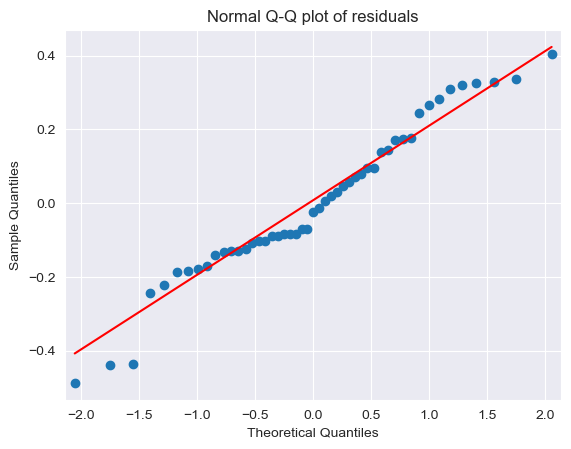

In [166]:
# Residuals values = y - yhat
sm.qqplot(final_model.resid,line='q')
plt.title('Normal Q-Q plot of residuals')
plt.show()

### Residual Plot for Homoscedasticity

In [167]:
def get_standardized_values(vals):
    return (vals - vals.mean())/vals.std()

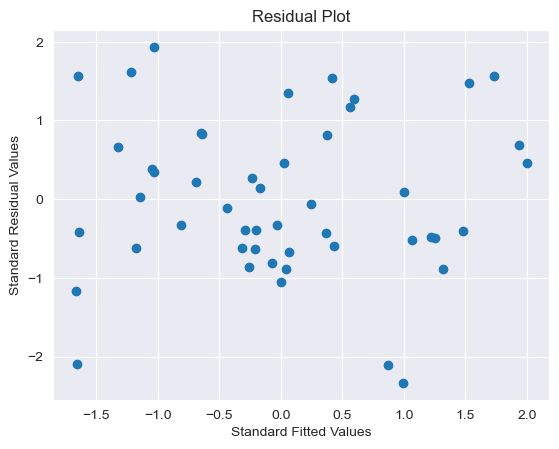

In [168]:
plt.scatter(get_standardized_values(final_model.fittedvalues),get_standardized_values(final_model.resid))
plt.title('Residual Plot')
plt.xlabel('Standard Fitted Values')
plt.ylabel('Standard Residual Values')
plt.show()

### Observation: Constant Variance (Homoscedasticity) in Error
### Residual VS Regressors
- Plotting to visualize the partial relation of each independent feature with the Dependent variable and errors

eval_env: 1


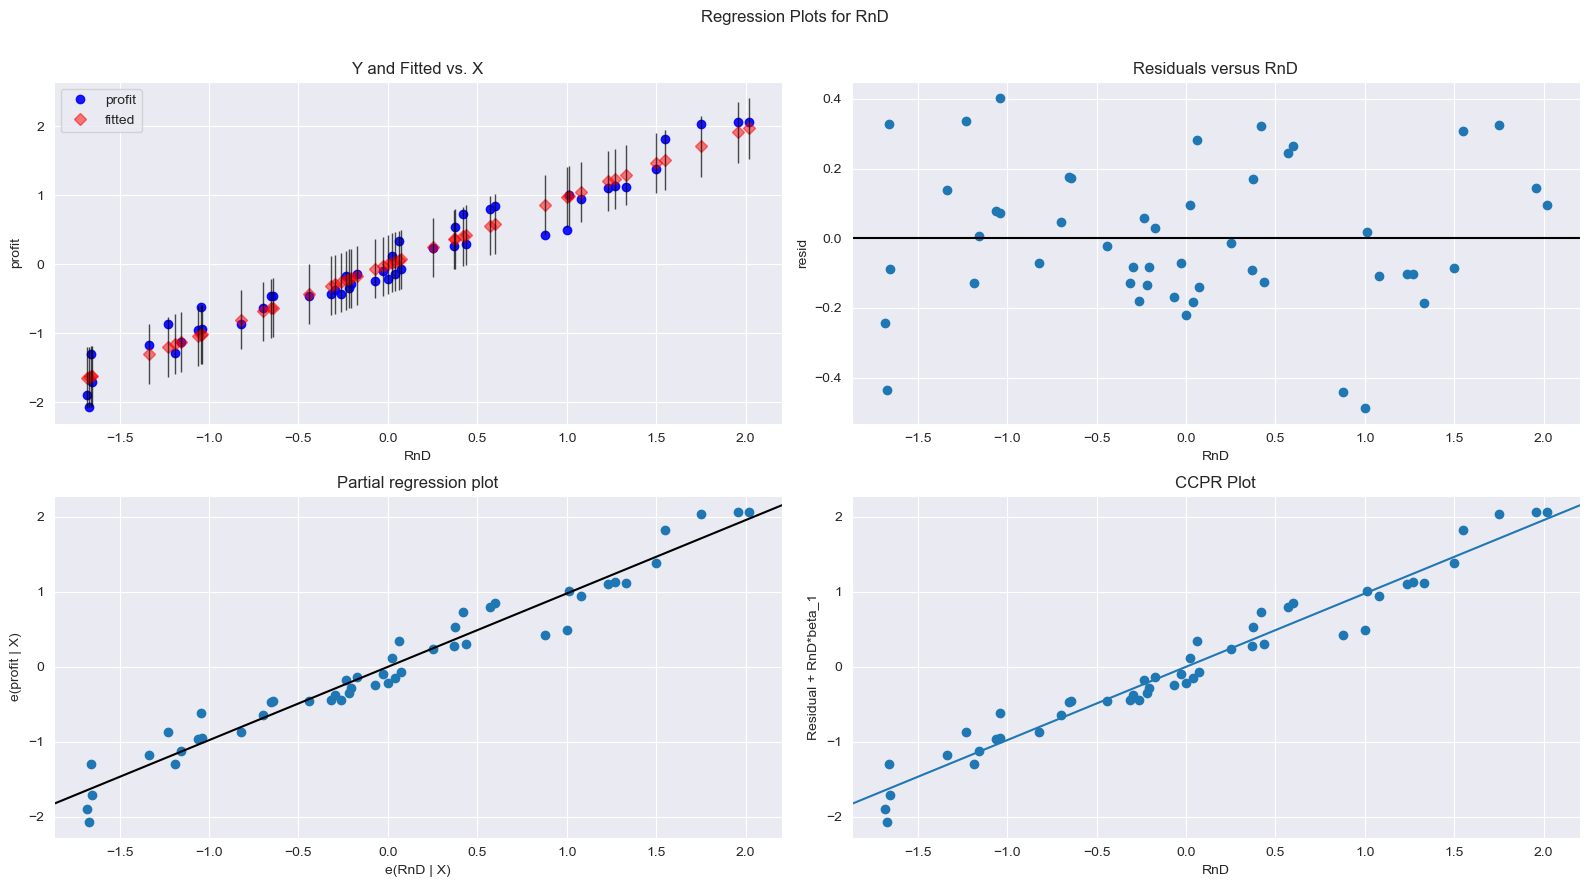

In [170]:
fig = plt.figure(figsize=(16,9))
plot_RnD = sm.graphics.plot_regress_exog(final_model,'RnD',fig=fig)
plt.show()

### Observation:
- Each Feature and Model Error (residuals) should be independent of each other
- There should be a linear relation between the dependent variable and Independent variables
### Note: All our assumptions are satisfied. Hence, we can say our model is a good model let us test more to make it even better
### Detecting Influencers/Outliers in the Model
- By using Cook's Distance

In [171]:
influence_points = final_model.get_influence()
c, p_value= influence_points.cooks_distance

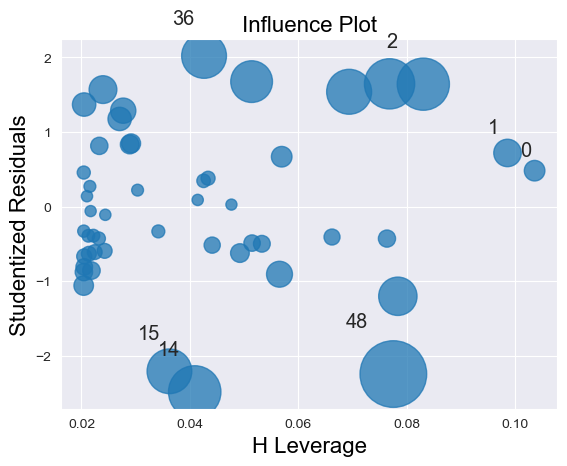

In [172]:
# Leverage Value using High Influence Points : Points beyond Leverage_cutoff value are influencers
influence_plot(final_model)
plt.show()

### Leverage Cuttoff Value = 3*(k+1)/n ; k = no.of features/columns & n = no. of datapoints

In [173]:
k = df4.shape[1]
n = df4.shape[0]
leverage_cutoff = (3*(k+1))/n
print('Cut-off line at',np.round(leverage_cutoff,2))

Cut-off line at 0.31


### Let's plot the influencers and also plot a cut off line using the stem plot

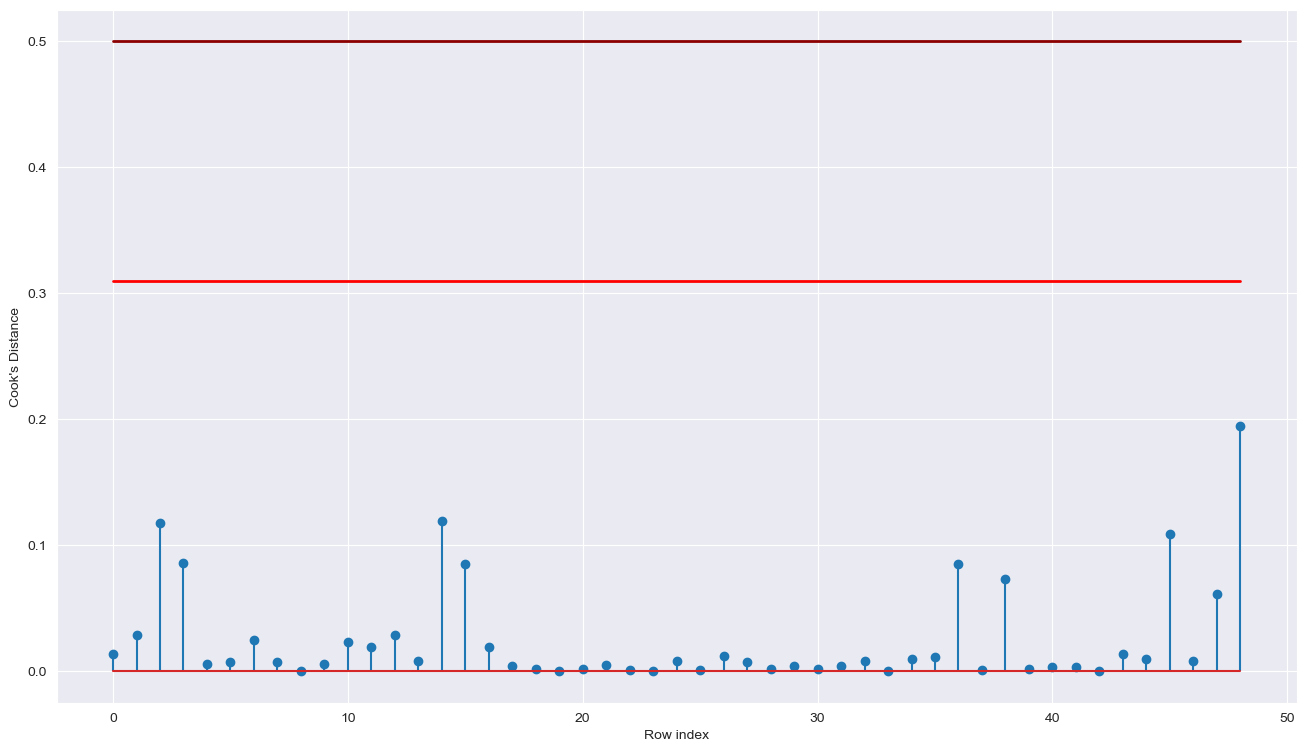

In [175]:
fig = plt.figure(figsize=(16,9))
x = [0,48]
y = [0.5,0.5]
plt.plot(x,y,color='darkred',linewidth=2)
y1 = [0.31,0.31]
plt.plot(x,y1,color='red',linewidth=2)
plt.stem(np.arange(len(df4)),np.round(c,3))
plt.xlabel('Row index')
plt.ylabel("Cook's Distance")
plt.show()

### Observation: All the points are below our cut-off line
- Hence, we can say that there are no influncers present in our model we can proceed with the predictions
### Predicting values from Model using same dataset

In [176]:
# Scale the test dataset
X_test_scaled = transformer_x.transform(df4.RnD.values.reshape(-1,1))

# Predict with the trained model
prediction = regressor_linear_using_rnd.predict(X_test_scaled)

# Inverse transform the prediction
prediction_unscaled = transformer_y.inverse_transform(prediction)

In [178]:
predicted = pd.DataFrame(prediction_unscaled, columns = ['Predicted_Profit'])
predicted['Profit'] = df4['profit']
predicted['RnD'] = df2['RnD']
predicted.head()

,Predicted_Profit,Profit,RnD
0,188741.633166,192261.83,165349.20
1,186461.632949,191792.06,162597.70
2,178874.456794,191050.39,153441.51
3,171359.446810,182901.99,144372.41
4,169482.521463,166187.94,142107.34


### Table containing R^2 value for each prepared model

In [179]:
models={'Different_Models':['Raw_data','Median_Imputation_Outlier','Mean_Imputation_outlier','Removed_outlier','Using All Features Model','Using RnD and Marketing Feature Model','Using only R&D Feauture Model'],
        'R_squared':[raw_model.rsquared,after_median_imputation_model.rsquared,after_mean_imputation_model.rsquared,removed_outlier_model.rsquared,r2_score_all_feature_train,r2_score_rnd_and_marketing_train,r2_score_rnd_train],
        'R_squared_adjusted':[raw_model.rsquared_adj,after_median_imputation_model.rsquared_adj,after_mean_imputation_model.rsquared_adj,removed_outlier_model.rsquared_adj,model.rsquared_adj,marketing_present_model.rsquared_adj,only_RnD_model.rsquared_adj],
       'RMSE':[np.sqrt(raw_model.mse_resid),np.sqrt(after_median_imputation_model.mse_resid),np.sqrt(after_mean_imputation_model.mse_resid),np.sqrt(removed_outlier_model.mse_resid),rmse_linear_using_all_features,rmse_linear_using_RnD_and_marketing,rmse_linear_using_only_RnD]}
model_table=pd.DataFrame(models)
model_table

,Different_Models,R_squared,R_squared_adjusted,RMSE
0,Raw_data,0.950746,0.947534,9232.334837
1,Median_Imputation_Outlier,0.918296,0.912967,11148.345424
2,Mean_Imputation_outlier,0.911954,0.906212,11570.325358
3,Removed_outlier,0.961316,0.958737,7753.807752
4,Using All Features Model,0.965020,0.958737,8385.783571
5,Using RnD and Marketing Feature Model,0.964354,0.959394,8059.317765
6,Using only R&D Feauture Model,0.957733,0.956432,7152.417058


### Visualizing Models Performance

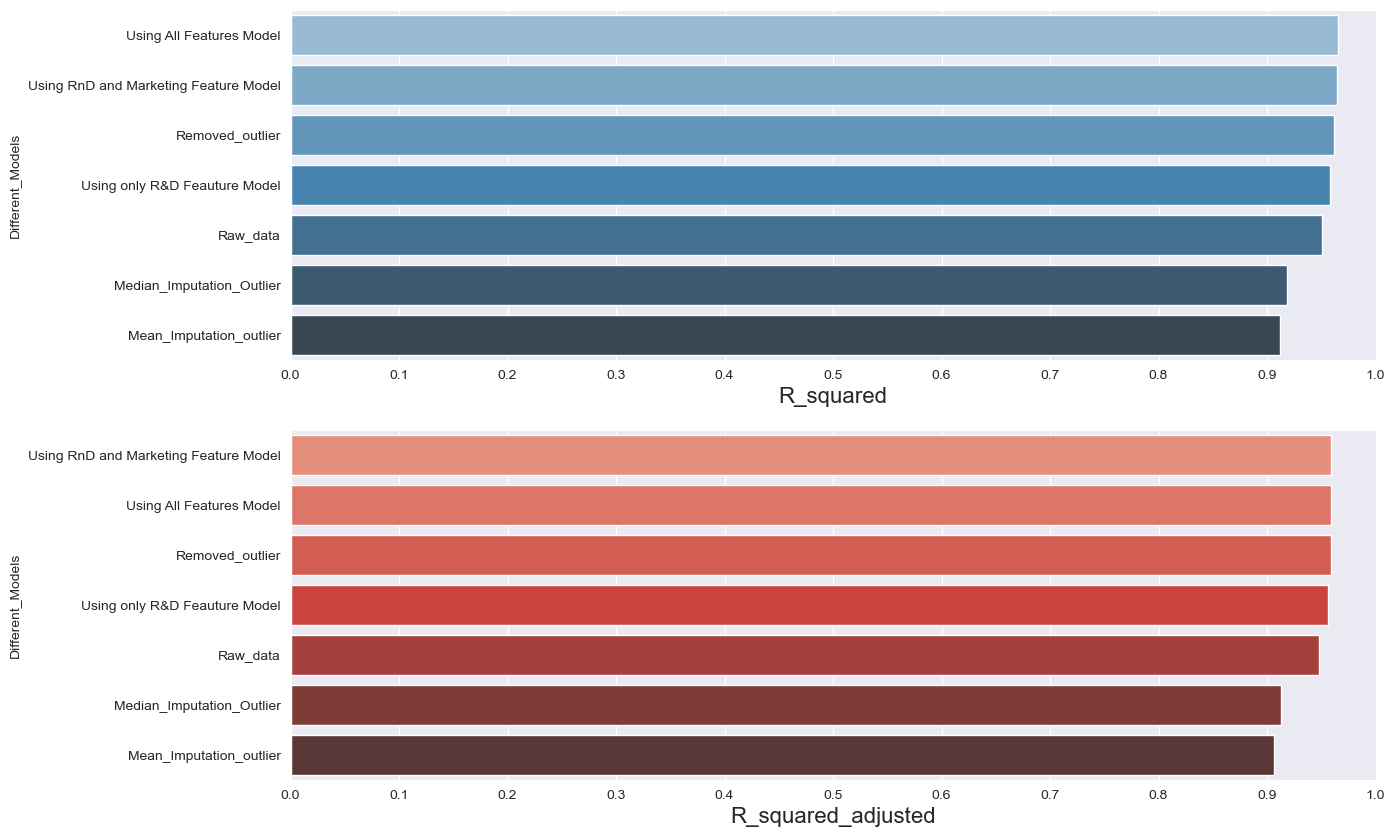

In [182]:
f, axes = plt.subplots(2,1, figsize=(14,10))

model_table.sort_values(by=['R_squared'], ascending=False, inplace=True)

sns.barplot(x='R_squared', y='Different_Models', data = model_table, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('R_squared', size=16)
axes[0].set_ylabel('Different_Models')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

model_table.sort_values(by=['R_squared_adjusted'], ascending=False, inplace=True)

sns.barplot(x='R_squared_adjusted', y='Different_Models', data = model_table, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('R_squared_adjusted', size=16)
axes[1].set_ylabel('Different_Models')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

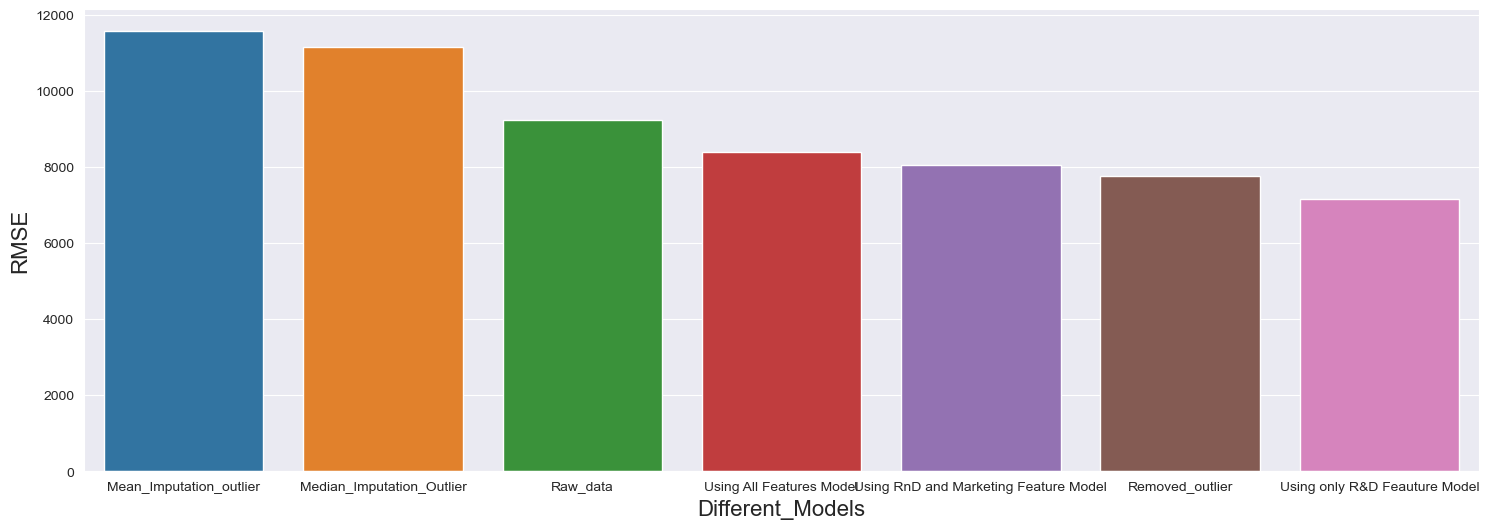

In [183]:
model_table.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Different_Models', y='RMSE', data=model_table, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()